In [2]:
# [ python 3.12 ]
# !conda create -n ai_env python=3.12 -y
# !conda activate ai_env

In [3]:
# !pip install numpy pandas matplotlib seaborn -q

In [4]:
# !pip install ipykernel scikit-learn tqdm -q

In [5]:
# !pip install statsmodels -q
# !pip install pmdarima -q # for auto_arima

In [6]:
#### linux 버전 확인용
# !pip install distro -q

In [7]:
# #!pip install scikit-optimize -q
# !pip install 'scikit-optimize[plots]' -q # plot functionality

In [8]:
# !pip install optuna -q
# !pip install plotly -q
# !pip install nbformat -q

## 1. Import

In [9]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from tqdm import tqdm

In [10]:
from sklearn import datasets, ensemble # sklearn tree models

In [11]:
import statsmodels.tsa.stattools as ts

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns

In [13]:
# 한글 폰트 설정
import matplotlib
import matplotlib.font_manager as fm
import platform

# OS 정보
os_name = platform.system()         # Windows / Linux / Darwin
os_version = platform.release()     # 11, 8.1, 22.04 등은 직접 매핑 필요

"""
OS	            NT 버전 (platform.version()의 major.minor 부분)	대표 빌드 번호
Windows 8.0	    6.2	                                            9200
Windows 8.1	    6.3	                                            9600
Windows 10	    10.0	                                        10240 ~ 19045
Windows 11	    10.0	                                        22000 / 22621 / 22631 / 26100
""" 

# C:\Windows\Fonts   # ==> Windows OS에 등록되어 있는 모든 폰트 파일들
if os_name == "Windows":
    # Windows 11 / Windows 8.1 구분하기
    # platform.release()가 10으로 나오는 경우도 있어 version() 검사 필요
    version_detail = platform.version()

    if "10.0" in version_detail:
        # Windows 11 or Windows 10 버전: 10.0
        print("→ Windows 11 (or 10) detected")
        font_path = 'C:\\Windows\\Fonts\\H2GTRM.TTF' # 윈도우 OS, Windows11 폰트 경로

    elif "6.3" in version_detail:
        # Windows 8.1 버전: 6.3
        print("→ Windows 8.1 detected")
        font_path = 'C:\\Windows\\Fonts\\batang.ttc' # 윈도우 OS, Windows8.1 폰트 경로

    else:
        print("→ Unknown Windows version:", version_detail)
        
# '~/.local/share/fonts/' or '/usr/share/fonts/opentype/noto/NotoSerifCJK-Regular.ttc' # Ubuntu 22.04 폰트 경로
elif os_name == "Linux":
    # Ubuntu 버전 확인
    import distro   # pip install distro (필요 시)

    linux_name = distro.name()
    linux_version = distro.version()

    if linux_name == "Ubuntu" and linux_version.startswith("22.04"):
        print("→ Ubuntu 22.04 detected")
        font_path = '/home/yypark/.local/share/fonts/D2Coding-Ver1.3.2-20180524.ttf' # Ubuntu 22.04 폰트 경로
    else:
        print(f"→ Other Linux distro: {linux_name} {linux_version}")
        font_path = '/usr/share/fonts/opentype/noto/NotoSerifCJK-Regular.ttc' # Ubuntu 폰트 경로

else:
    print("Unsupported OS:", os_name)
    

font_prop = fm.FontProperties(fname = font_path) # 폰트경로에 있는 폰트 이름들 뽑아오자.
font_name = font_prop.get_name() # 폰트명

#matplotlib.rc('font', key=value)
matplotlib.rc('font', family=font_name)

# matplotlib이 기본적으로 사용하는 유니코드 마이너스 비활성화
# -> 아스키코드의 마이너스 사용
plt.rc('axes', unicode_minus=False) # matplotlib의 기본적인 유니코드 minus폰트사용 중지

→ Ubuntu 22.04 detected


In [14]:
def safe_corr(x, y):
    """_summary_

    Args:
        x (_type_): _description_
        y (_type_): _description_

    Returns:
        _type_: _description_
    """
    if np.std(x) == 0 or np.std(y) == 0:
        return 0.0
    return float(np.corrcoef(x, y)[0, 1])

def find_comovement_pairs(pivot, max_lag=6, min_nonzero=12, corr_threshold=0.4):
    """_summary_
    - 각 (A, B) 쌍에 대해 lag = 1 ~ max_lag까지 Pearson 상관계수 계산
    - 절댓값이 가장 큰 상관계수와 lag를 선택
    - |corr| >= corr_threshold이면 A→B 공행성 있다고 판단
    Args:
        pivot (_type_): _description_
        max_lag (int, optional): _description_. Defaults to 6.
        min_nonzero (int, optional): _description_. Defaults to 12.
        corr_threshold (float, optional): _description_. Defaults to 0.4.

    Returns:
        _type_: _description_
    """
    items = pivot.index.to_list()
    months = pivot.columns.to_list()
    n_months = len(months)

    results = []

    for i, leader in tqdm(enumerate(items)):
        x = pivot.loc[leader].values.astype(float)
        if np.count_nonzero(x) < min_nonzero:
            continue

        for follower in items:
            if follower == leader:
                continue

            y = pivot.loc[follower].values.astype(float)
            if np.count_nonzero(y) < min_nonzero:
                continue

            best_lag = None
            best_corr = 0.0

            # lag = 1 ~ max_lag 탐색
            for lag in range(1, max_lag + 1):
                if n_months <= lag:
                    continue
                corr = safe_corr(x[:-lag], y[lag:])
                if abs(corr) > abs(best_corr):
                    best_corr = corr
                    best_lag = lag

            # 임계값 이상이면 공행성쌍으로 채택
            if best_lag is not None and abs(best_corr) >= corr_threshold:
                results.append({
                    "leading_item_id": leader,
                    "following_item_id": follower,
                    "best_lag": best_lag,
                    "max_corr": best_corr,
                })

    pairs = pd.DataFrame(results)
    return pairs



In [15]:
#####  기본값: find_comovement_pairs_mod(pivot, max_lag=6, min_lag = 1, min_nonzero=12, corr_threshold=0.4)
def find_comovement_pairs_mod(pivot, max_lag=6, min_lag = 1, min_nonzero=12, corr_threshold=0.4):
    """_summary_
    - 각 (A, B) 쌍에 대해 lag = 0 ~ max_lag까지 Pearson 상관계수 계산
    - 절댓값이 가장 큰 상관계수와 lag를 선택
    - |corr| >= corr_threshold이면 A→B 공행성 있다고 판단
    Args:
        pivot (_type_): _description_
        max_lag (int, optional): _description_. Defaults to 6.
        min_lag (int, optional): _description_. Defaults to 1.
        min_nonzero (int, optional): _description_. Defaults to 12.
        corr_threshold (float, optional): _description_. Defaults to 0.4.

    Returns:
        _type_: _description_
    """
    items = pivot.index.to_list()
    months = pivot.columns.to_list()
    n_months = len(months)

    results = []

    for i, leader in tqdm(enumerate(items)):
        x = pivot.loc[leader].values.astype(float)
        if np.count_nonzero(x) < min_nonzero:
            continue

        for follower in items:
            if follower == leader:
                continue

            y = pivot.loc[follower].values.astype(float)
            if np.count_nonzero(y) < min_nonzero:
                continue

            best_lag = None
            best_corr = 0.0

            ## lag = 1 ~ max_lag 탐색
            #for lag in range(1, max_lag + 1):
            # lag = 0 ~ max_lag 탐색
            for lag in range(min_lag, max_lag + 1):
                if n_months <= lag:
                    continue
                if lag == 0: corr = safe_corr(x[:], y[lag:])
                else: corr = safe_corr(x[:-lag], y[lag:])
                
                if abs(corr) > abs(best_corr):
                    best_corr = corr
                    best_lag = lag

            # 임계값 이상이면 공행성쌍으로 채택
            if best_lag is not None and abs(best_corr) >= corr_threshold:
                results.append({
                    "leading_item_id": leader,
                    "following_item_id": follower,
                    "best_lag": best_lag,
                    "max_corr": best_corr,
                })

    pairs = pd.DataFrame(results)
    return pairs


In [16]:

def find_comovement_pairs_diff(pivot, max_lag=6, min_nonzero=12, corr_threshold=0.4):
    items = pivot.index.to_list()
    months = pivot.columns.to_list()
    n_months = len(months)

    results = []

    for i, leader in tqdm(enumerate(items)):
        #x = pivot.loc[leader].values.astype(float)
        x_raw = pivot.loc[leader].values.astype(float)
        if np.count_nonzero(x_raw) < min_nonzero:
            continue

        x = np.diff(x_raw) # 변화량, 1차분
        for follower in items:
            if follower == leader:
                continue

            #y = pivot.loc[follower].values.astype(float)
            y_raw = pivot.loc[follower].values.astype(float)
            if np.count_nonzero(y_raw) < min_nonzero:
                continue
            
            y = np.diff(y_raw) # 변화량, 1차분

            best_lag = None
            best_corr = 0.0

            # lag = 1 ~ max_lag 탐색
            for lag in range(1, max_lag + 1):
                if (n_months-1) <= lag: # diff로 데이터 1개 줄어서 n_months-1 (43 -> 42)
                    continue
                
                # x_diff[:-lag], y_diff[lag:] 비교
                corr = safe_corr(x[:-lag], y[lag:])
                if abs(corr) > abs(best_corr):
                    best_corr = corr
                    best_lag = lag

            # 임계값 이상이면 공행성쌍으로 채택
            if best_lag is not None and abs(best_corr) >= corr_threshold:
                results.append({
                    "leading_item_id": leader,
                    "following_item_id": follower,
                    "best_lag": best_lag,
                    "max_corr": best_corr,
                })

    pairs = pd.DataFrame(results)
    return pairs

# pairs_diff = find_comovement_pairs_diff(pivot)
# print("탐색된 공행성쌍 수:", len(pairs_diff)) 
# pairs_diff.head()

In [17]:
#####  기본값: find_comovement_pairs_mod(pivot, max_lag=6, min_lag = 1, min_nonzero=12, corr_threshold=0.4)
def find_comovement_pairs_mod_diff(pivot, max_lag=6, min_lag = 1, min_nonzero=12, corr_threshold=0.4):
    """_summary_
    - 각 (A, B) 쌍에 대해 lag = 0 ~ max_lag까지 Pearson 상관계수 계산
    - 절댓값이 가장 큰 상관계수와 lag를 선택
    - |corr| >= corr_threshold이면 A→B 공행성 있다고 판단
    Args:
        pivot (_type_): _description_
        max_lag (int, optional): _description_. Defaults to 6.
        min_lag (int, optional): _description_. Defaults to 1.
        min_nonzero (int, optional): _description_. Defaults to 12.
        corr_threshold (float, optional): _description_. Defaults to 0.4.

    Returns:
        _type_: _description_
    """
    items = pivot.index.to_list()
    months = pivot.columns.to_list()
    n_months = len(months)

    results = []

    for i, leader in tqdm(enumerate(items)):
        # x = pivot.loc[leader].values.astype(float)
        x_raw = pivot.loc[leader].values.astype(float)
        if np.count_nonzero(x_raw) < min_nonzero:
            continue

        x = np.diff(x_raw) # 변화량 1차분 계산, 데이터 1개 줄어듦
        for follower in items:
            if follower == leader:
                continue

            # y = pivot.loc[follower].values.astype(float)
            y_raw = pivot.loc[follower].values.astype(float)
            if np.count_nonzero(y_raw) < min_nonzero:
                continue

            y = np.diff(y_raw) # 변화량 1차분 계산, 데이터 1개 줄어듦
            best_lag = None
            best_corr = 0.0

            ## lag = 1 ~ max_lag 탐색
            #for lag in range(1, max_lag + 1):
            # lag = 0 ~ max_lag 탐색
            for lag in range(min_lag, max_lag + 1):
                # if n_months <= lag:
                if (n_months-1) <= lag: # 데이터 1개 줄어서 n_months-1(43 -> 42)
                    continue

                # x_diff[:-lag] 와 y_diff[lag:] 비교
                if lag == 0: corr = safe_corr(x[:], y[lag:])
                else: corr = safe_corr(x[:-lag], y[lag:])
                
                if abs(corr) > abs(best_corr):
                    best_corr = corr
                    best_lag = lag

            # 임계값 이상이면 공행성쌍으로 채택
            if best_lag is not None and abs(best_corr) >= corr_threshold:
                results.append({
                    "leading_item_id": leader,
                    "following_item_id": follower,
                    "best_lag": best_lag,
                    "max_corr": best_corr,
                })

    pairs = pd.DataFrame(results)
    return pairs

# pairs_mod_diff = find_comovement_pairs_mod_diff(pivot, min_lag = 0)
# print("탐색된 공행성쌍 수:", len(pairs_mod_diff)) 
# pairs_mod_diff.head()

In [18]:

def plot_histogram(input_var_col: pd.Series|pd.DataFrame, num_bin: int,
                    title_str: str = "한 item에 대한 following_item 갯수 분포 히스토그램",
                    xlbl_str: str = 'following_item 갯수',
                    verbose=False):
    
    if type(input_var_col) == pd.Series: ser = input_var_col
    elif type(input_var_col) == pd.DataFrame: ser = input_var_col.squeeze(axis=1)
    else: 
        print("Wrong input: input should be pd.Series or pd.DataFrame of single column")
        return 
    
    #fig = plt.figure(figsize=(10,10))
    #df_pairs_mod.plot(kind='hist', bins=10)
    # (최대값 - 최소값) / bins
    # plt.hist(scores, bins =10) # bins = 10, 기본값
    count, bins, container = plt.hist(ser, bins=num_bin, edgecolor='k', rwidth=.9) # 
    if verbose:
        print('count :', count) # count : [    1.   2.   1.     3.   3.     3.   2.     5.]
        print('bins :', bins)   # bins :  [60. 64.25 68.5  72.75 77.   81.25 85.5  89.75 94.  ]
        print('container :', container) # container : <BarContainer object of 8 artists>
        for i in range(len(bins)-1):
            print(f'{bins[i]} ~ {bins[i+1]} : {int(count[i])}개')

    plt.xlabel(xlbl_str)
    plt.ylabel('Count')
    #plt.ylim([0, 20])
    #plt.yticks([0, 3, 6, 9, 12, 15, 18])
    plt.grid(axis='y')

    plt.title(title_str)
    plt.show()

In [19]:
def build_training_data(pivot, pairs):
    """
    공행성쌍 + 시계열을 이용해 (X, y) 학습 데이터를 만드는 함수
    input X:
      - b_t, b_t_1, a_t_lag, max_corr, best_lag
    target y:
      - b_t_plus_1
    """
    months = pivot.columns.to_list()
    n_months = len(months)

    rows = []

    for row in pairs.itertuples(index=False):
        leader = row.leading_item_id
        follower = row.following_item_id
        lag = int(row.best_lag)
        corr = float(row.max_corr)

        if leader not in pivot.index or follower not in pivot.index:
            continue

        a_series = pivot.loc[leader].values.astype(float)
        b_series = pivot.loc[follower].values.astype(float)

        # t+1이 존재하고, t-lag >= 0인 구간만 학습에 사용
        for t in range(max(lag, 1), n_months - 1):
            b_t = b_series[t]
            b_t_1 = b_series[t - 1]
            a_t_lag = a_series[t - lag]
            b_t_plus_1 = b_series[t + 1]

            rows.append({
                "b_t": b_t,
                "b_t_1": b_t_1,
                "a_t_lag": a_t_lag,
                "max_corr": corr,
                "best_lag": float(lag),
                "target": b_t_plus_1,
            })

    df_train = pd.DataFrame(rows)
    return df_train

In [20]:
def build_training_data_fe(pivot, pairs, add_fe = ['wv_cat', 'seq_cat', 'hs4_cat']):
    """
    공행성쌍 + 시계열을 이용해 (X, y) 학습 데이터를 만드는 함수 
    + engineered feature 추가
    input X:
      - b_t, b_t_1, a_t_lag, max_corr, best_lag
      - add_fe = ['wv_cat']
    target y:
      - b_t_plus_1
    """
    months = pivot.columns.to_list()
    n_months = len(months)

    rows = []

    for row in pairs.itertuples(index=False):
        leader = row.leading_item_id
        follower = row.following_item_id
        lag = int(row.best_lag)
        corr = float(row.max_corr)
        # add Feat.Eng.
        wv_cat = int(row.wv_cat)
        seq_cat = int(row.seq_cat)
        hs4_cat = int(row.hs4_cat)
          

        if leader not in pivot.index or follower not in pivot.index:
            continue

        a_series = pivot.loc[leader].values.astype(float)
        b_series = pivot.loc[follower].values.astype(float)

        # t+1이 존재하고, t-lag >= 0인 구간만 학습에 사용
        for t in range(max(lag, 1), n_months - 1):
            b_t = b_series[t]
            b_t_1 = b_series[t - 1]
            a_t_lag = a_series[t - lag]
            b_t_plus_1 = b_series[t + 1]

            rows.append({
                "b_t": b_t,
                "b_t_1": b_t_1,
                "a_t_lag": a_t_lag,
                "max_corr": corr,
                "best_lag": float(lag),
                "wv_cat": float(wv_cat),
                "seq_cat": float(seq_cat),
                "hs4_cat": float(hs4_cat),
                "target": b_t_plus_1,
            })

    df_train = pd.DataFrame(rows)
    return df_train

In [21]:
def predict(pivot, pairs, mdl):
    """_summary_

    Args:
        pivot (_type_): _description_
        pairs (_type_): _description_
        mdl (_type_): _description_

    Returns:
        _type_: _description_
    """
    months = pivot.columns.to_list()
    n_months = len(months) # 43

    # 가장 마지막 두 달 index (2025-7, 2025-6)
    t_last = n_months - 1 # 42 as index (43 months 경우)
    t_prev = n_months - 2 # 41 as index (43 months 경우)

    preds = []

    for row in tqdm(pairs.itertuples(index=False)):
        leader = row.leading_item_id
        follower = row.following_item_id
        ##### features added other than 'value'
        lag = int(row.best_lag)
        corr = float(row.max_corr)

        if leader not in pivot.index or follower not in pivot.index:
            ##### 기본값 설정필요
            continue

        a_series = pivot.loc[leader].values.astype(float)   # Leader TS
        b_series = pivot.loc[follower].values.astype(float) # Follower TS

        # t_last - lag 가 0 이상인 경우만 예측
        if t_last - lag < 0:
            ##### 기본값 설정필요
            continue

        b_t = b_series[t_last]
        b_t_1 = b_series[t_prev]
        a_t_lag = a_series[t_last - lag]

        X_test = np.array([[b_t, b_t_1, a_t_lag, corr, float(lag)]])
        y_pred = mdl.predict(X_test)[0]

        # (후처리 1) 음수 예측 → 0으로 변환
        # (후처리 2) 소수점 → 정수 변환 (무역량은 정수 단위)
        y_pred = max(0.0, float(y_pred))
        y_pred = int(round(y_pred))

        preds.append({
            "leading_item_id": leader,
            "following_item_id": follower,
            "value": y_pred,
        })

    df_pred = pd.DataFrame(preds)
    return df_pred

In [22]:
def predict_fe(pivot, pairs, mdl, add_fe = ['wv_cat', 'seq_cat', 'hs4_cat']):
    """_summary_

    Args:
        pivot (_type_): _description_
        pairs (_type_): _description_
        mdl (_type_): _description_

    Returns:
        _type_: _description_
    """
    months = pivot.columns.to_list()
    n_months = len(months) # 43

    # 가장 마지막 두 달 index (2025-7, 2025-6)
    t_last = n_months - 1 # 42 as index (43 months 경우)
    t_prev = n_months - 2 # 41 as index (43 months 경우)

    preds = []

    for row in tqdm(pairs.itertuples(index=False)):
        leader = row.leading_item_id
        follower = row.following_item_id
        ##### features added other than 'value'
        lag = int(row.best_lag)
        corr = float(row.max_corr)
        wv_cat = int(row.wv_cat)
        seq_cat = int(row.seq_cat)
        hs4_cat = int(row.hs4_cat)

        if leader not in pivot.index or follower not in pivot.index:
            ##### 기본값 설정필요
            continue

        a_series = pivot.loc[leader].values.astype(float)   # Leader TS
        b_series = pivot.loc[follower].values.astype(float) # Follower TS

        # t_last - lag 가 0 이상인 경우만 예측
        if t_last - lag < 0:
            ##### 기본값 설정필요
            continue

        b_t = b_series[t_last]
        b_t_1 = b_series[t_prev]
        a_t_lag = a_series[t_last - lag]

        #X_test = np.array([[b_t, b_t_1, a_t_lag, corr, float(lag)]])
        #X_test = np.array([[b_t, b_t_1, a_t_lag, corr, float(lag), float(wv_cat)]])     
        #X_test = np.array([[b_t, b_t_1, a_t_lag, corr, float(lag), float(wv_cat), float(seq_cat)]])     
        X_test = np.array([[b_t, b_t_1, a_t_lag, corr, float(lag), float(wv_cat), float(seq_cat), float(hs4_cat)]])    
        y_pred = mdl.predict(X_test)[0]

        # (후처리 1) 음수 예측 → 0으로 변환
        # (후처리 2) 소수점 → 정수 변환 (무역량은 정수 단위)
        y_pred = max(0.0, float(y_pred))
        y_pred = int(round(y_pred))

        preds.append({
            "leading_item_id": leader,
            "following_item_id": follower,
            "value": y_pred,
        })

    df_pred = pd.DataFrame(preds)
    return df_pred

In [23]:
def predict_local(pivot, pairs, mdl):
    pass

In [24]:
def _validate_input(answer_df, submission_df):
    # ① 컬럼 개수·이름 일치 여부
    if len(answer_df.columns) != len(submission_df.columns) or not all(answer_df.columns == submission_df.columns):
        raise ValueError("The columns of the answer and submission dataframes do not match.")


    # ② 필수 컬럼에 NaN 존재 여부
    if submission_df.isnull().values.any():
        raise ValueError("The submission dataframe contains missing values.")


    # ③ pair 중복 여부
    pairs = list(zip(submission_df["leading_item_id"], submission_df["following_item_id"]))
    if len(pairs) != len(set(pairs)):
        raise ValueError("The submission dataframe contains duplicate (leading_item_id, following_item_id) pairs.")


def comovement_f1(answer_df, submission_df):
    """공행성쌍 F1 계산"""
    ans = answer_df[["leading_item_id", "following_item_id"]].copy()
    sub = submission_df[["leading_item_id", "following_item_id"]].copy()


    ans["pair"] = list(zip(ans["leading_item_id"], ans["following_item_id"]))
    sub["pair"] = list(zip(sub["leading_item_id"], sub["following_item_id"]))


    G = set(ans["pair"])
    P = set(sub["pair"])


    tp = len(G & P)
    fp = len(P - G)
    fn = len(G - P)


    precision = tp / (tp + fp) if (tp + fp) > 0 else 0.0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0.0
    f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0.0


    return f1



def comovement_nmae(answer_df, submission_df, eps=1e-6):
    """
    전체 U = G ∪ P에 대한 clipped NMAE 계산
    """
    ans = answer_df[["leading_item_id", "following_item_id", "value"]].copy()
    sub = submission_df[["leading_item_id", "following_item_id", "value"]].copy()


    ans["pair"] = list(zip(ans["leading_item_id"], ans["following_item_id"]))
    sub["pair"] = list(zip(sub["leading_item_id"], sub["following_item_id"]))


    G = set(ans["pair"])
    P = set(sub["pair"])
    U = G | P


    ans_val = dict(zip(ans["pair"], ans["value"]))
    sub_val = dict(zip(sub["pair"], sub["value"]))


    errors = []
    for pair in U:
        if pair in G and pair in P:
            # 정수 변환(반올림) (b/c 무역량은 정수)
            y_true = int(round(float(ans_val[pair])))
            y_pred = int(round(float(sub_val[pair])))
            rel_err = abs(y_true - y_pred) / (abs(y_true) + eps)
            rel_err = min(rel_err, 1.0) # 오차 100% 이상은 100%로 간주
        else:
            rel_err = 1.0  # FN, FP는 오차 100%
        errors.append(rel_err)


    return np.mean(errors) if errors else 1.0


def comovement_score(answer_df, submission_df, verbose=True):
    _validate_input(answer_df, submission_df)
    S1 = comovement_f1(answer_df, submission_df)
    
    nmae_full = comovement_nmae(answer_df, submission_df, 1e-6)
    S2 = 1 - nmae_full
    
    score = 0.6 * S1 + 0.4 * S2
    if verbose:
        print("#"*40)
        print(f'S1: comovement_f1(answer_df, submission_df): {S1}')
        print(f'S2: 1 - comovement_nmae(answer_df, submission_df, 1e-6): {1- nmae_full}')
        print(f'score(=0.6*S1 + 0.4*S2): {score}')
    return score


In [25]:
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error


def local_MAE(y_true, y_pred, eps=1e-6):
    """로컬 테스팅에서의 오차계산 comovement_nmae 변형"""
        # 정수 변환(반올림) (b/c 무역량은 정수)
    y_true = int(round(float(y_true)))
    y_pred = int(round(float( y_pred)))
    abs_err = abs(y_true - y_pred)
    return abs_err


def local_MAPE1(y_true, y_pred, eps=1e-6):
    """로컬 테스팅에서의 오차계산 comovement_nmae 변형
        the percentage in the range [0, 100] is converted to a relative value in the range [0, 1] by dividing by 100. 
        Thus, an error of 200% corresponds to a relative error of 2.
    """
        # 정수 변환(반올림) (b/c 무역량은 정수)
    y_true = np.round(y_true.astype(float)).astype(int)
    y_pred = np.round(y_pred.astype(float)).astype(int)
    #rel_err = abs(y_true - y_pred) / (abs(y_true) + eps)
    ##rel_err = min(rel_err, 1.0) # 오차 100% 이상은 100%로 간주
    ##return rel_err if rel_err else 1.0
    #return min(rel_err, 1.0)
    rel_err = np.abs(y_true - y_pred) / (np.abs(y_true) + eps)
    #return np.sum(np.where(rel_err < 1.0, rel_err, 1.0))/len(rel_err)
    return np.mean(np.where(rel_err < 1.0, rel_err, 1.0))


def local_MAPE2(y_true, y_pred):
    """로컬 테스팅에서의 오차계산 comovement_nmae 변형
        scikit-learn  mean_absolute_percentage_error()이용
        an error of 200% corresponds to a relative error of 2. ==> maybe wrong (element-wise min(x, 1)필요).
    """
    #return np.mean(min(mean_absolute_percentage_error(y_true, y_pred), 1)) # 오차 100% 이상은 100%로 간주  ==> maybe wrong (element-wise min(x, 1)필요).
    return mean_absolute_percentage_error(y_true, y_pred) 


    

In [64]:
#####
#####  NS(n=22)는 차분(=1)으로 S로 변환하고, 원래 S(n=78) 을 다 포함하여 상관관계를 구하자.
##### 

# lst_items_adf_ns = list(dct_items_adf_ns.keys())
# lst_items_adf_s= list(dct_items_adf_s.keys())

# ser_ns_diff = pivot.loc[list(dct_items_adf_ns.keys())].apply(lambda x: np.diff(x), axis=1)
# pivot_ns_diff_m42 = pd.DataFrame([lst for lst in ser_ns_diff.values], index=ser_ns_diff.index, columns = pivot.columns[1:])
# pivot_s_m42  = pivot.loc[list(dct_items_adf_s.keys())].drop(["2022-01-01"], axis=1)
# # 여기서 pivot은 pivot_s_m42 +pivot_ns_diff_m42의 모든 items이름 얻기 위함

def find_comovement_pairs_diff_ns(pivot, 
                                  pivot_ns_diff_m42, pivot_s_m42, lst_items_adf_ns, lst_items_adf_s,
                                  max_lag=6, min_nonzero=12, corr_threshold=0.4):
    items = pivot.index.to_list()
    #months = pivot.columns.to_list()
    months = pivot_ns_diff_m42.columns.to_list()
    
    n_months = len(months)
    print(f'n_months = {n_months}')
    
    results = []

    for i, leader in tqdm(enumerate(items)):
        ##x = pivot.loc[leader].values.astype(float)
        #x_raw = pivot.loc[leader].values.astype(float)
        if leader in lst_items_adf_ns:
            x = pivot_ns_diff_m42.loc[leader].values.astype(float) # 변화량, 1차분 (42months)
        elif leader in lst_items_adf_s:
            x = pivot_s_m42.loc[leader].values.astype(float) # level (42months)
        else:
            print(f"{leader} not in pivot.index ==> ERROR!!!" )
            
        if np.count_nonzero(x) < min_nonzero:
            continue

        #x = np.diff(x_raw) # 변화량, 1차분
        for follower in items:
            if follower == leader:
                continue

            ##y = pivot.loc[follower].values.astype(float)
            #y_raw = pivot.loc[follower].values.astype(float)
            if follower in lst_items_adf_ns:
                y = pivot_ns_diff_m42.loc[follower].values.astype(float) # 변화량, 1차분 (42months)
            elif follower in lst_items_adf_s:
                y = pivot_s_m42.loc[follower].values.astype(float) # level (42months)
            else:
                print(f"{follower} not in pivot.index ==> ERROR!!!" )           
            
            if np.count_nonzero(y) < min_nonzero:
                continue
            
            #y = np.diff(y_raw) # 변화량, 1차분
            best_lag = None
            best_corr = 0.0

            # lag = 1 ~ max_lag 탐색
            for lag in range(1, max_lag + 1):
                if (n_months-1) <= lag: # diff로 데이터 1개 줄어서 n_months-1 (43 -> 42)
                    continue
                
                # x_diff[:-lag], y_diff[lag:] 비교
                corr = safe_corr(x[:-lag], y[lag:])
                if abs(corr) > abs(best_corr):
                    best_corr = corr
                    best_lag = lag

            # 임계값 이상이면 공행성쌍으로 채택
            if best_lag is not None and abs(best_corr) >= corr_threshold:
                results.append({
                    "leading_item_id": leader,
                    "following_item_id": follower,
                    "best_lag": best_lag,
                    "max_corr": best_corr,
                })

    pairs = pd.DataFrame(results)
    return pairs

# pairs_diff_ns = find_comovement_pairs_diff_ns(pivot)
# print("탐색된 공행성쌍 수:", len(pairs_diff_ns)) 
# pairs_diff_ns.head()

## 0.  파라미터 설정

In [27]:
# a) 공햏성쌍 탐색 함수 파라미터 세팅 (default: min_lag=1, max_lag=6, min_nonzero=12, corr_threshold=0.4)
min_lag=1
max_lag=6 
min_nonzero=12 
corr_threshold=0.4

# b) LinearRegression 모델 파라미터 세팅(defaut: )

# 설정파라미터 로깅
EXP_LOG = {} # 테스트 파라미터 값 저장 딕셔너리 ==> 일단 이건 고정하고, feat.eng.와 model에 변화주며 테스팅
EXP_LOG['min_lag'] = 1
EXP_LOG['max_lag'] = 6
EXP_LOG['min_nonzero'] = 12
EXP_LOG['corr_threshold'] = 0.4

## 1. 무역 데이터 로딩

### train.csv

In [28]:
train = pd.read_csv('../data/train.csv')
train.head(3)

,item_id,year,month,seq,type,hs4,weight,quantity,value
0,DEWLVASR,2022,1,1.0,1,3038,14858.0,0.0,32688.0
1,ELQGMQWE,2022,1,1.0,1,2002,62195.0,0.0,110617.0
2,AHMDUILJ,2022,1,1.0,1,2102,18426.0,0.0,72766.0


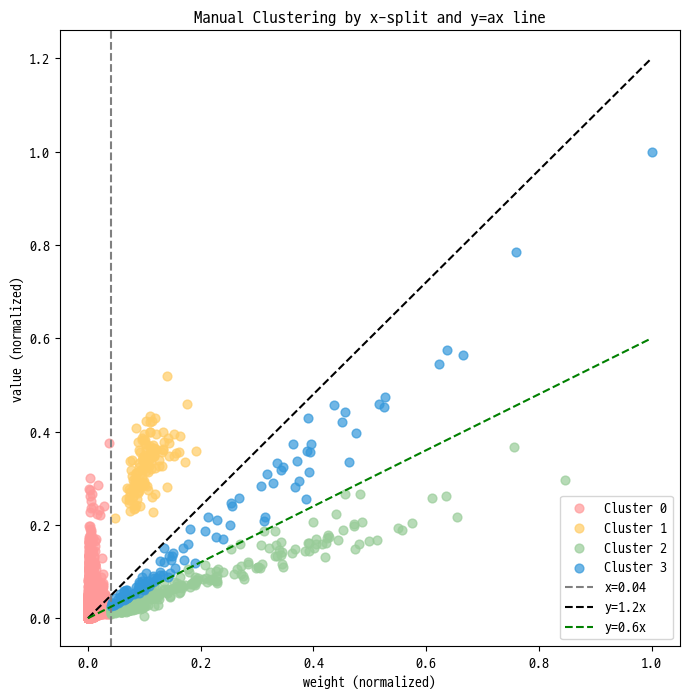

In [29]:
######
###### feature engineering 1:  weight-value categorizattion via manual clustering
######

# 최대 weight 값 기준 정규화 (0~1 범위로 맞추면 시각화 깔끔)
x = train['weight'] / train['weight'].max()
y = train['value'] / train['value'].max()

# 기준선 설정
x_split = 0.04     # x=0.3 경계선
a = 1.2            # y = a*x 기준선 (기울기)
b = 0.6            # y = b*x 기준선 (기울기)
train['cluster_manual'] = 0  # 기본값


#plt.imshow((x > x_split) & (y > a * x))



# 조건별 군집 분류
train.loc[(x <= x_split), 'cluster_manual'] = 0 # 분홍색 군집
train.loc[(x > x_split) & (y > a * x), 'cluster_manual'] = 1 # 노란색 군집
train.loc[(x > x_split) & (y <= a * x), 'cluster_manual'] = 2 # 초록색 군집
train.loc[(x > x_split) & (y <= a * x) & (y >= b * x), 'cluster_manual'] = 3 # 파란색 군집
############################################################################
# 시각화
plt.figure(figsize=(8,8))
colors = ['#FF9999','#FFCC66','#99CC99', '#3498db']
for i, color in enumerate(colors):
    plt.scatter(x[train['cluster_manual']==i],
                y[train['cluster_manual']==i],
                label=f'Cluster {i}', s=40, color=color, alpha=0.7)


# 기준선들 시각화
plt.axvline(x=x_split, color='gray', linestyle='--', label=f'x={x_split}')
plt.plot(np.linspace(0,1,100),
         a * np.linspace(0,1,100),
         color='black', linestyle='--', label=f'y={a}x')
plt.plot(np.linspace(0,1,100),
         b * np.linspace(0,1,100),
         color='green', linestyle='--', label=f'y={b}x')

plt.xlabel('weight (normalized)')
plt.ylabel('value (normalized)')
plt.title('Manual Clustering by x-split and y=ax line')
plt.legend()
plt.show()

In [30]:
train.head(3)

,item_id,year,month,seq,type,hs4,weight,quantity,value,cluster_manual
0,DEWLVASR,2022,1,1.0,1,3038,14858.0,0.0,32688.0,0
1,ELQGMQWE,2022,1,1.0,1,2002,62195.0,0.0,110617.0,0
2,AHMDUILJ,2022,1,1.0,1,2102,18426.0,0.0,72766.0,0


In [31]:
#train.groupby(['item_id' ,'cluster_manual'])['item_id'].size()
print(train.groupby('cluster_manual')['item_id'].apply(lambda x: len(np.unique(x))))
train.groupby('cluster_manual')['item_id'].apply(lambda x: np.unique(x))

cluster_manual
0    99
1     1
2     7
3     4
Name: item_id, dtype: int64


cluster_manual
0    [AANGBULD, AHMDUILJ, ANWUJOKX, APQGTRMF, ATLDM...
1                                           [FCYBOAXC]
2    [ATLDMDBO, BTMOEMEP, HXYSSRXE, LLHREMKS, LRVGF...
3             [ATLDMDBO, BTMOEMEP, LRVGFDFM, SDWAYPIK]
Name: item_id, dtype: object

In [32]:
tmp_df_seq = train.groupby(["cluster_manual"], as_index=False)["item_id"].apply(lambda x: np.unique(x))
tmp_df_seq['cluster_manual_len'] = train.groupby(["cluster_manual"])["item_id"].apply(lambda x: len(np.unique(x))).values#['item_id']#.sort_values(by='item_id', ascending=False, key = lambda x: len(x), axis=1)#.reset_index(drop=True)['item_id']
tmp_df_seq

dct_seq_cat = tmp_df_seq[['cluster_manual','item_id']].set_index('cluster_manual').to_dict()['item_id']
dct_seq_cat

{0: array(['AANGBULD', 'AHMDUILJ', 'ANWUJOKX', 'APQGTRMF', 'ATLDMDBO',
        'AXULOHBQ', 'BEZYMBBT', 'BJALXPFS', 'BLANHGYY', 'BSRMSVTC',
        'BTMOEMEP', 'BUZIIBYG', 'CCLHWFWF', 'DBWLZWNK', 'DDEXPPXU',
        'DEWLVASR', 'DJBLNPNC', 'DNMPSKTB', 'DUCMGGNW', 'ELQGMQWE',
        'EVBVXETX', 'FDXPMYGF', 'FITUEHWN', 'FQCLOEXA', 'FRHNWLNI',
        'FTSVTTSR', 'FWUCPMMW', 'GIKPEWTY', 'GKQIJYDH', 'GMBFCMIU',
        'GYHKIVQT', 'HCDTGMST', 'HXYSSRXE', 'IGDVVKUD', 'JBVHSUWY',
        'JERHKLYW', 'JPBRUTWP', 'JSLXRQOK', 'KAGJCHMR', 'KEUWZRKO',
        'KFQSHBNH', 'KJNSOAHR', 'LLHREMKS', 'LPHPPJUG', 'LRVGFDFM',
        'LSOIUSXD', 'LTOYKIML', 'LUENUFGA', 'MBSBZBXA', 'MIRCVAMV',
        'NAQIHUKZ', 'NZKBIBNU', 'OGAFEHLU', 'OJIFIHMZ', 'OKMBFVKS',
        'OXKURKXR', 'PLMZALFA', 'PYZMVUWD', 'QJQJSWFU', 'QKXNTIIB',
        'QRKRBYJL', 'QSDCUCLB', 'QVLMOEYE', 'RAWUKQMJ', 'RCBZUSIM',
        'RJCAXSGH', 'RJGPVEXX', 'ROACSLMG', 'RUVXNNVA', 'SAAYMURU',
        'SAHWCZNH', 'SDWAYPIK', 'SNHYOVBM', '

In [33]:
len(set(dct_seq_cat[0])), len(set(dct_seq_cat[1])), len(set(dct_seq_cat[2])), len(set(dct_seq_cat[3]))

(99, 1, 7, 4)

In [34]:
print(set(dct_seq_cat[0]).intersection(set(dct_seq_cat[1]))) # 중복 없음
print(sorted(set(dct_seq_cat[0]).intersection(set(dct_seq_cat[2])))) # ['ATLDMDBO', 'BTMOEMEP', 'HXYSSRXE', 'LLHREMKS', 'LRVGFDFM', 'SDWAYPIK', 'XMKRPGLB']
print(set(dct_seq_cat[1]).intersection(set(dct_seq_cat[2]))) # 중복 없음
print(sorted(set(dct_seq_cat[0]).intersection(set(dct_seq_cat[3])))) # ['ATLDMDBO', 'BTMOEMEP', 'LRVGFDFM', 'SDWAYPIK']
print(set(dct_seq_cat[1]).intersection(set(dct_seq_cat[3]))) # 중복 없음
print(sorted(set(dct_seq_cat[2]).intersection(set(dct_seq_cat[3])))) # ['ATLDMDBO', 'BTMOEMEP', 'LRVGFDFM', 'SDWAYPIK']

set()
['ATLDMDBO', 'BTMOEMEP', 'HXYSSRXE', 'LLHREMKS', 'LRVGFDFM', 'SDWAYPIK', 'XMKRPGLB']
set()
['ATLDMDBO', 'BTMOEMEP', 'LRVGFDFM', 'SDWAYPIK']
set()
['ATLDMDBO', 'BTMOEMEP', 'LRVGFDFM', 'SDWAYPIK']


In [35]:
dct_wv_cat_inv = {1:['FCYBOAXC'], 
              2:['ATLDMDBO', 'BTMOEMEP', 'LRVGFDFM', 'SDWAYPIK'], 
              3:['HXYSSRXE', 'LLHREMKS', 'XMKRPGLB'], 
              4:sorted(set(dct_seq_cat[0]).difference(set(dct_seq_cat[2]))) }
dct_wv_cat_inv[4][:10]

['AANGBULD',
 'AHMDUILJ',
 'ANWUJOKX',
 'APQGTRMF',
 'AXULOHBQ',
 'BEZYMBBT',
 'BJALXPFS',
 'BLANHGYY',
 'BSRMSVTC',
 'BUZIIBYG']

In [36]:
dct_wv_cat = {}
for k, v in dct_wv_cat_inv.items():
    for item in v:
        dct_wv_cat[item] = k
len(dct_wv_cat) # fe-weight-value cat. dictionary

100

In [37]:
######
###### feature engineering 2:  seq-item_id categorization
######

seq_pivot_df_cnt = pd.pivot_table(train, index='item_id', columns="month", values='seq',aggfunc='count', margins=True, margins_name="seq_total")

tmp_ser = seq_pivot_df_cnt['seq_total'].iloc[:-1]
dct_seq_total = pd.cut(tmp_ser, bins= [0, 40, 80, tmp_ser.max()], labels = ['seq_cnt_low',  'seq_cnt_mid',  'seq_cnt_high'] ).to_dict()
dct_seq_total

train['seq_cat'] = train["item_id"].map(dct_seq_total)
display(train.head(3))

tmp_df_seq = train.groupby(["seq_cat"], as_index=False)["item_id"].apply(lambda x: np.unique(x))
tmp_df_seq['seq_cat_len'] = train.groupby(["seq_cat"])["item_id"].apply(lambda x: len(np.unique(x))).values

dct_seq_cat_inv = tmp_df_seq[['seq_cat','item_id']].set_index('seq_cat').to_dict()['item_id']
dct_seq_cat_inv


,item_id,year,month,seq,type,hs4,weight,quantity,value,cluster_manual,seq_cat
0,DEWLVASR,2022,1,1.0,1,3038,14858.0,0.0,32688.0,0,seq_cnt_high
1,ELQGMQWE,2022,1,1.0,1,2002,62195.0,0.0,110617.0,0,seq_cnt_high
2,AHMDUILJ,2022,1,1.0,1,2102,18426.0,0.0,72766.0,0,seq_cnt_high


{'seq_cnt_high': array(['AHMDUILJ', 'APQGTRMF', 'ATLDMDBO', 'AXULOHBQ', 'BEZYMBBT',
        'BJALXPFS', 'BSRMSVTC', 'BTMOEMEP', 'BUZIIBYG', 'CCLHWFWF',
        'DBWLZWNK', 'DDEXPPXU', 'DEWLVASR', 'DNMPSKTB', 'DUCMGGNW',
        'ELQGMQWE', 'EVBVXETX', 'FCYBOAXC', 'FDXPMYGF', 'FITUEHWN',
        'FQCLOEXA', 'FRHNWLNI', 'FTSVTTSR', 'GKQIJYDH', 'GYHKIVQT',
        'HCDTGMST', 'HXYSSRXE', 'IGDVVKUD', 'JBVHSUWY', 'JERHKLYW',
        'JPBRUTWP', 'JSLXRQOK', 'KAGJCHMR', 'KEUWZRKO', 'KJNSOAHR',
        'LLHREMKS', 'LPHPPJUG', 'LRVGFDFM', 'LSOIUSXD', 'LTOYKIML',
        'LUENUFGA', 'MBSBZBXA', 'NZKBIBNU', 'OJIFIHMZ', 'OKMBFVKS',
        'OXKURKXR', 'QJQJSWFU', 'QKXNTIIB', 'QRKRBYJL', 'QVLMOEYE',
        'RAWUKQMJ', 'RCBZUSIM', 'RJGPVEXX', 'ROACSLMG', 'SAAYMURU',
        'SAHWCZNH', 'SDWAYPIK', 'SNHYOVBM', 'STZDBITS', 'SUOYXCHP',
        'UGEQLMXM', 'UIFPPCLR', 'UQYUIVVR', 'UXSPKBJR', 'VBYCLTYZ',
        'VMAQSTJE', 'VUAFAIYJ', 'VWMBASNE', 'WBLJNPZQ', 'WHPUAOID',
        'WPQXWHYO', 'WQMVCOEM', 

In [38]:
dct_seq_cat = {}
for k, v in dct_seq_cat_inv.items():
    for item in v:
        if k=="seq_cnt_low": dct_seq_cat[item] = 1
        elif k=="seq_cnt_mid": dct_seq_cat[item] = 2
        elif k=="seq_cnt_high": dct_seq_cat[item] = 3
len(dct_seq_cat) # fe-seq-item_id cat. dictionary

100

In [39]:
######
###### feature engineering 3:  seq-item_id categorization
######

tmp_df = train.groupby(["hs4"], as_index=False)["item_id"].apply(lambda x: np.unique(x))
tmp_df['item_id_len'] = train.groupby(["hs4"], as_index=False)["item_id"].apply(lambda x: len(np.unique(x)))['item_id']
hs4_tmp_df = tmp_df.sort_values(by='item_id_len', ascending=False).reset_index(drop=True)
display(hs4_tmp_df.head(20))
print(hs4_tmp_df['hs4'][:20].values) # [2805 3824 8501 2811 8102 8505 3815 2807 7207 2846 3102 2529 8714 1210 2002 2701 2612 2501 2102 2836]
print(hs4_tmp_df.shape) # (71, 3)
hs4_tmp_df['item_id_len'][:20].sum() # 49

,hs4,item_id,item_id_len
0,2805,"[BSRMSVTC, DJBLNPNC, RCBZUSIM, SUOYXCHP, WQMVC...",6
1,3824,"[FCYBOAXC, IGDVVKUD, LPHPPJUG, PYZMVUWD, SNHYO...",5
2,8501,"[GKQIJYDH, KFQSHBNH, QKXNTIIB, RJCAXSGH, UQYUI...",5
3,2811,"[DNMPSKTB, RJGPVEXX, VWMBASNE, WPQXWHYO]",4
4,8102,"[FQCLOEXA, KEUWZRKO, UIFPPCLR]",3
5,8505,"[GYHKIVQT, ROACSLMG, VBYCLTYZ]",3
6,3815,"[OJIFIHMZ, STZDBITS, XIIEJNEE]",3
7,2807,"[DDEXPPXU, LLHREMKS, YSYHGLQK]",3
8,7207,"[SDWAYPIK, TGOELCAG]",2
9,2846,"[FRHNWLNI, MBSBZBXA]",2


[2805 3824 8501 2811 8102 8505 3815 2807 7207 2846 3102 2529 8714 1210
 2002 2701 2612 2501 2102 2836]
(71, 3)


np.int64(49)

In [40]:
# for i, row in enumerate(hs4_tmp_df):
#     print(i, row)
#     #break

tmp_seq = [ x if x < 14 else 14 for x in range(1, len(hs4_tmp_df)+1) ]
hs4_tmp_df['hs4_cat'] = tmp_seq
pd.concat([hs4_tmp_df.head(15), hs4_tmp_df.tail(5)])


,hs4,item_id,item_id_len,hs4_cat
0,2805,"[BSRMSVTC, DJBLNPNC, RCBZUSIM, SUOYXCHP, WQMVC...",6,1
1,3824,"[FCYBOAXC, IGDVVKUD, LPHPPJUG, PYZMVUWD, SNHYO...",5,2
2,8501,"[GKQIJYDH, KFQSHBNH, QKXNTIIB, RJCAXSGH, UQYUI...",5,3
3,2811,"[DNMPSKTB, RJGPVEXX, VWMBASNE, WPQXWHYO]",4,4
4,8102,"[FQCLOEXA, KEUWZRKO, UIFPPCLR]",3,5
5,8505,"[GYHKIVQT, ROACSLMG, VBYCLTYZ]",3,6
6,3815,"[OJIFIHMZ, STZDBITS, XIIEJNEE]",3,7
7,2807,"[DDEXPPXU, LLHREMKS, YSYHGLQK]",3,8
8,7207,"[SDWAYPIK, TGOELCAG]",2,9
9,2846,"[FRHNWLNI, MBSBZBXA]",2,10


In [41]:
display(hs4_tmp_df[hs4_tmp_df['hs4']==4202]) # 42	4202	[QVLMOEYE]	1	14

display(hs4_tmp_df[hs4_tmp_df['hs4']==2833])

display(hs4_tmp_df[hs4_tmp_df['hs4']==4302])

,hs4,item_id,item_id_len,hs4_cat
42,4202,[QVLMOEYE],1,14


,hs4,item_id,item_id_len,hs4_cat
37,2833,[LUENUFGA],1,14


,hs4,item_id,item_id_len,hs4_cat
41,4302,[TANNMIMB],1,14


In [42]:
cp_hs4_tmp_df = hs4_tmp_df[['hs4_cat','item_id']].copy()
print(cp_hs4_tmp_df[hs4_tmp_df['hs4_cat']==14].shape)
lst_hs4_cat14 = []
for item in cp_hs4_tmp_df[hs4_tmp_df['hs4_cat']==14]['item_id']:
    lst_hs4_cat14.append(item.tolist()[0])
    
print(len(lst_hs4_cat14))
lst_hs4_cat14



(58, 2)
58


['JBVHSUWY',
 'ELQGMQWE',
 'FWUCPMMW',
 'RUVXNNVA',
 'XIPPENFQ',
 'AHMDUILJ',
 'HXYSSRXE',
 'QRKRBYJL',
 'BJALXPFS',
 'ATLDMDBO',
 'DEWLVASR',
 'PLMZALFA',
 'ZGJXVMNI',
 'UXSPKBJR',
 'QJQJSWFU',
 'EVBVXETX',
 'BEZYMBBT',
 'SAAYMURU',
 'NAQIHUKZ',
 'DUCMGGNW',
 'JPBRUTWP',
 'RAWUKQMJ',
 'GMBFCMIU',
 'SAHWCZNH',
 'LUENUFGA',
 'QSDCUCLB',
 'MIRCVAMV',
 'ANWUJOKX',
 'TANNMIMB',
 'QVLMOEYE',
 'LTOYKIML',
 'JERHKLYW',
 'AANGBULD',
 'ZXERAXWP',
 'WHPUAOID',
 'AXULOHBQ',
 'DBWLZWNK',
 'LSOIUSXD',
 'JSLXRQOK',
 'XUOIQPFL',
 'WBLJNPZQ',
 'OXKURKXR',
 'CCLHWFWF',
 'VUAFAIYJ',
 'HCDTGMST',
 'OKMBFVKS',
 'NZKBIBNU',
 'FDXPMYGF',
 'OGAFEHLU',
 'GIKPEWTY',
 'KAGJCHMR',
 'ZCELVYQU',
 'APQGTRMF',
 'KJNSOAHR',
 'VMAQSTJE',
 'XIFHSOWQ',
 'BLANHGYY',
 'BUZIIBYG']

In [43]:
dct_hs4_cat_inv = hs4_tmp_df[['hs4_cat','item_id']][:13].set_index('hs4_cat').to_dict()['item_id']
dct_hs4_cat_inv[14] = np.array(lst_hs4_cat14)
dct_hs4_cat_inv

{1: array(['BSRMSVTC', 'DJBLNPNC', 'RCBZUSIM', 'SUOYXCHP', 'WQMVCOEM',
        'ZKENOUDA'], dtype=object),
 2: array(['FCYBOAXC', 'IGDVVKUD', 'LPHPPJUG', 'PYZMVUWD', 'SNHYOVBM'],
       dtype=object),
 3: array(['GKQIJYDH', 'KFQSHBNH', 'QKXNTIIB', 'RJCAXSGH', 'UQYUIVVR'],
       dtype=object),
 4: array(['DNMPSKTB', 'RJGPVEXX', 'VWMBASNE', 'WPQXWHYO'], dtype=object),
 5: array(['FQCLOEXA', 'KEUWZRKO', 'UIFPPCLR'], dtype=object),
 6: array(['GYHKIVQT', 'ROACSLMG', 'VBYCLTYZ'], dtype=object),
 7: array(['OJIFIHMZ', 'STZDBITS', 'XIIEJNEE'], dtype=object),
 8: array(['DDEXPPXU', 'LLHREMKS', 'YSYHGLQK'], dtype=object),
 9: array(['SDWAYPIK', 'TGOELCAG'], dtype=object),
 10: array(['FRHNWLNI', 'MBSBZBXA'], dtype=object),
 11: array(['BTMOEMEP', 'LRVGFDFM'], dtype=object),
 12: array(['FTSVTTSR', 'XMKRPGLB'], dtype=object),
 13: array(['FITUEHWN', 'UGEQLMXM'], dtype=object),
 14: array(['JBVHSUWY', 'ELQGMQWE', 'FWUCPMMW', 'RUVXNNVA', 'XIPPENFQ',
        'AHMDUILJ', 'HXYSSRXE', 'QRKRBYJL', 'BJ

In [44]:
dct_hs4_cat = {}
for k, v in dct_hs4_cat_inv.items():
    for item in v:
        dct_hs4_cat[item] = k
print(len(dct_hs4_cat)) # fe-hs4-item_id cat. dictionary
#dct_hs4_cat

100


### monthly data


In [45]:
# year, month, item_id 기준으로 value 합산 (seq만 다르다면 value 합산)
monthly = (
    train
    .groupby(["item_id", "year", "month"], as_index=False)["value"]
    .sum()
)

# year, month를 하나의 키(ym)로 묶기
monthly["ym"] = pd.to_datetime(
    monthly["year"].astype(str) + "-" + monthly["month"].astype(str).str.zfill(2)
)

monthly.head()

,item_id,year,month,value,ym
0,AANGBULD,2022,1,14276.0,2022-01-01
1,AANGBULD,2022,2,52347.0,2022-02-01
2,AANGBULD,2022,3,53549.0,2022-03-01
3,AANGBULD,2022,5,26997.0,2022-05-01
4,AANGBULD,2022,6,84489.0,2022-06-01


### pivot

In [46]:
# item_id × ym 피벗 (월별 총 무역량 매트릭스 생성)
pivot_org = (
    monthly
    .pivot(index="item_id", columns="ym", values="value")
    .fillna(0.0)
)

print("pivot_org.shape: ", pivot_org.shape)
pivot_org.head()

pivot_org.shape:  (100, 43)


ym,2022-01-01,2022-02-01,2022-03-01,2022-04-01,2022-05-01,2022-06-01,2022-07-01,2022-08-01,2022-09-01,2022-10-01,...,2024-10-01,2024-11-01,2024-12-01,2025-01-01,2025-02-01,2025-03-01,2025-04-01,2025-05-01,2025-06-01,2025-07-01
item_id,,,,,,,,,,,,,,,,,,,,,
AANGBULD,14276.0,52347.0,53549.0,0.0,26997.0,84489.0,0.0,0.0,0.0,0.0,...,428725.0,144248.0,26507.0,25691.0,25805.0,0.0,38441.0,0.0,441275.0,533478.0
AHMDUILJ,242705.0,120847.0,197317.0,126142.0,71730.0,149138.0,186617.0,169995.0,140547.0,89292.0,...,123085.0,143451.0,78649.0,125098.0,80404.0,157401.0,115509.0,127473.0,89479.0,101317.0
ANWUJOKX,0.0,0.0,0.0,63580.0,81670.0,26424.0,8470.0,0.0,0.0,80475.0,...,0.0,0.0,0.0,27980.0,0.0,0.0,0.0,0.0,0.0,0.0
APQGTRMF,383999.0,512813.0,217064.0,470398.0,539873.0,582317.0,759980.0,216019.0,537693.0,205326.0,...,683581.0,2147.0,0.0,25013.0,77.0,20741.0,2403.0,3543.0,32430.0,40608.0
ATLDMDBO,143097177.0,103568323.0,118403737.0,121873741.0,115024617.0,65716075.0,146216818.0,97552978.0,72341427.0,87454167.0,...,60276050.0,30160198.0,42613728.0,64451013.0,38667429.0,29354408.0,42450439.0,37136720.0,32181798.0,57090235.0


In [47]:
##### 로컬 테스팅을 위해, pivot.iloc[:, :-1]과 pivot.iloc[:, [-1]]로  split
target_pivot = pivot_org.iloc[:, [-1]].copy()
pivot = pivot_org.iloc[:, :-1].copy()

print("pivot.shape: ", pivot.shape)
pivot.head(3)

pivot.shape:  (100, 42)


ym,2022-01-01,2022-02-01,2022-03-01,2022-04-01,2022-05-01,2022-06-01,2022-07-01,2022-08-01,2022-09-01,2022-10-01,...,2024-09-01,2024-10-01,2024-11-01,2024-12-01,2025-01-01,2025-02-01,2025-03-01,2025-04-01,2025-05-01,2025-06-01
item_id,,,,,,,,,,,,,,,,,,,,,
AANGBULD,14276.0,52347.0,53549.0,0.0,26997.0,84489.0,0.0,0.0,0.0,0.0,...,313076.0,428725.0,144248.0,26507.0,25691.0,25805.0,0.0,38441.0,0.0,441275.0
AHMDUILJ,242705.0,120847.0,197317.0,126142.0,71730.0,149138.0,186617.0,169995.0,140547.0,89292.0,...,184920.0,123085.0,143451.0,78649.0,125098.0,80404.0,157401.0,115509.0,127473.0,89479.0
ANWUJOKX,0.0,0.0,0.0,63580.0,81670.0,26424.0,8470.0,0.0,0.0,80475.0,...,0.0,0.0,0.0,0.0,27980.0,0.0,0.0,0.0,0.0,0.0


In [48]:
# dictionary of "item_id": y_true value:
target_pivot.head()
target_pivot.to_dict().keys()#['2025-07-01 00:00:00']
dct_y_true = target_pivot.to_dict()[pd.to_datetime('2025-07-01')]

for k,v in dct_y_true.items():
    if v==0: print(k, v)

ANWUJOKX 0.0
GIKPEWTY 0.0
GMBFCMIU 0.0
HCDTGMST 0.0
NAQIHUKZ 0.0
OGAFEHLU 0.0
PLMZALFA 0.0
QSDCUCLB 0.0
RUVXNNVA 0.0
TANNMIMB 0.0


In [65]:
import statsmodels.tsa.stattools as ts

# ---------------------------------------------------------------
#  (각 데이터가 불안정한지 ADF 검정)
# ---------------------------------------------------------------
# p-value가 0.05보다 크면 '불안정하다(단위근이 있다)'는 뜻
print(f"#### ADF 검정 (불안정성 확인) ###")
dct_items_adf_ns = {} # filtered non-stationary items
dct_items_adf_s = {} # filtered stationary items
# for i, item in enumerate(pivot.index):
#     calc_p_val = ts.adfuller(pivot.loc[item])[1]
for i, item in enumerate(pivot_org.index):
    calc_p_val = ts.adfuller(pivot_org.loc[item])[1]    
    if calc_p_val>0.05:
        dct_items_adf_ns[item] = float(calc_p_val)
        #print(f"{str(item)} 데이터 p-value: {calc_p_val:.4f}") # p-value > 0.05 (불안정)
        #print("-" * 40)
    else:
        dct_items_adf_s[item] = float(calc_p_val)
        #print(f"{str(item)} 데이터 p-value: {calc_p_val:.4f}") # p-value > 0.05 (불안정)
        #print("-" * 40)
    
print(f'Non-Stationary ({len(dct_items_adf_ns)}개 items): {dct_items_adf_ns}') # Co-integration candidate
print(f'Stationary: ({len(dct_items_adf_s)}개 items): {dct_items_adf_s}')

#### ADF 검정 (불안정성 확인) ###


/home/yypark/miniconda3/envs/ai_env/lib/python3.12/site-packages/statsmodels/regression/linear_model.py:955: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2


Non-Stationary (22개 items): {'AANGBULD': 0.9894243389638399, 'ATLDMDBO': 0.09015018455087531, 'AXULOHBQ': 0.12483228858780177, 'DEWLVASR': 0.4066309984460655, 'DNMPSKTB': 0.06694244432401705, 'ELQGMQWE': 0.5796632646161022, 'EVBVXETX': 0.5026787470840136, 'FDXPMYGF': 0.19415742458957796, 'GYHKIVQT': 0.5820286118493817, 'HXYSSRXE': 0.6845220123708838, 'KJNSOAHR': 0.18326757326525778, 'LUENUFGA': 0.11496431273323404, 'OGAFEHLU': 0.07155197032381065, 'QVLMOEYE': 0.3570207443384179, 'RJCAXSGH': 0.975771249572837, 'RJGPVEXX': 0.11399148574516932, 'UIFPPCLR': 0.31526967079769136, 'VBYCLTYZ': 0.2512088712432241, 'WPQXWHYO': 0.3164867531446981, 'XIFHSOWQ': 0.17111521485938508, 'ZGJXVMNI': 0.8069737259832728, 'ZKENOUDA': 0.8611653905331763}
Stationary: (78개 items): {'AHMDUILJ': 8.311501923000167e-11, 'ANWUJOKX': 4.669152160421899e-05, 'APQGTRMF': 0.0002490891451913772, 'BEZYMBBT': 3.32041258890623e-06, 'BJALXPFS': 1.61689621586627e-07, 'BLANHGYY': 3.905882904779897e-05, 'BSRMSVTC': 4.2292938753

## 2. 공행성쌍 탐색

In [68]:
#####
##### 이제 NS(n=22)는 차분(=1)으로 S로 변환하고, 원래 S(n=78) 을 다 포함하여 상관관계를 구하자.
##### 

lst_items_adf_ns = list(dct_items_adf_ns.keys())
lst_items_adf_s= list(dct_items_adf_s.keys())

#ser_ns_diff = pivot.loc[list(dct_items_adf_ns.keys())].apply(lambda x: np.diff(x), axis=1)
#pivot_ns_diff_m42 = pd.DataFrame([lst for lst in ser_ns_diff.values], index=ser_ns_diff.index, columns = pivot.columns[1:])
ser_ns_diff = pivot_org.loc[list(dct_items_adf_ns.keys())].apply(lambda x: np.diff(x), axis=1)
pivot_ns_diff_m42 = pd.DataFrame([lst for lst in ser_ns_diff.values], index=ser_ns_diff.index, columns = pivot_org.columns[1:])

#pivot_s_m42  = pivot.loc[list(dct_items_adf_s.keys())].drop(["2022-01-01"], axis=1)
pivot_s_m42  = pivot_org.loc[list(dct_items_adf_s.keys())].drop(["2022-01-01"], axis=1)
# 여기서 pivot은 pivot_s_m42 +pivot_ns_diff_m42의 모든 items이름 얻기 위함

In [69]:
#pairs = find_comovement_pairs(pivot_org, max_lag, min_nonzero, corr_threshold) # pivot_org로 한것은 default pairs를 유지하기위함
#pairs = find_comovement_pairs_diff(pivot_org, max_lag, min_nonzero, corr_threshold) # pivot_org로 한것은 default pairs를 유지하기위함
pairs = find_comovement_pairs_diff_ns(pivot_org, 
                                      pivot_ns_diff_m42, pivot_s_m42, lst_items_adf_ns, lst_items_adf_s,
                                      max_lag, min_nonzero, corr_threshold)
print("탐색된 공행성쌍 수:", len(pairs)) # 탐색된 공행성쌍 수: 

EXP_LOG["탐색된 공행성쌍 pairs.shape"] = pairs.shape
pairs.head()

n_months = 42


100it [00:07, 13.16it/s]

탐색된 공행성쌍 수: 1014


,leading_item_id,following_item_id,best_lag,max_corr
0,AANGBULD,DEWLVASR,6,0.483517
1,AANGBULD,FTSVTTSR,3,0.437522
2,AANGBULD,GKQIJYDH,5,-0.433616
3,AANGBULD,LTOYKIML,1,0.449866
4,AANGBULD,NAQIHUKZ,2,0.464581


In [70]:
pairs['max_corr_abs'] = pairs['max_corr'].apply(np.abs)
pairs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1014 entries, 0 to 1013
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   leading_item_id    1014 non-null   object 
 1   following_item_id  1014 non-null   object 
 2   best_lag           1014 non-null   int64  
 3   max_corr           1014 non-null   float64
 4   max_corr_abs       1014 non-null   float64
dtypes: float64(2), int64(1), object(2)
memory usage: 39.7+ KB


In [71]:
df_pairs = pairs.groupby('leading_item_id')['following_item_id'] \
    .aggregate(["size"]).sort_values(by='size', ascending=False) # or 'count'
df_pairs    

###
### ==> 따라서 100개 아이템중 9개는 공행성쌍이 탐지 되지않았다. ==> 공행성쌍이 탐지 vs. 공행성쌍이 탐지 실패 아이템으로 cat. 가능 => 쓸모는 없다. 공행성쌍에 포함되지않으면 어차피 학습데이터로 들어가지않는다.
###

dct_pair_detection = {'comv_yes':df_pairs.index.to_list() , 
                      'comv_no': set(train['item_id']).difference(set(df_pairs.index.to_list()))}
print("공행성이 탐지되지 않은 상품수: ", len(dct_pair_detection['comv_no']))
print("공행성이 탐지되지 않은 상품id: ", sorted(dct_pair_detection['comv_no']))

print("공행성 탐지된 상품수: ", len(dct_pair_detection['comv_yes']))
print("공행성이 탐지된 상품id: ", sorted(dct_pair_detection['comv_yes'])) 
### logging
EXP_LOG["공행성이 탐지되지 않은 상품수"] = len(dct_pair_detection['comv_no'])
EXP_LOG["공행성이 탐지되지 않은 상품id:"] = sorted(dct_pair_detection['comv_no'])
EXP_LOG["공행성이 탐지된 상품수"] = len(dct_pair_detection['comv_yes'])

공행성이 탐지되지 않은 상품수:  9
공행성이 탐지되지 않은 상품id:  ['ANWUJOKX', 'GIKPEWTY', 'GMBFCMIU', 'KFQSHBNH', 'PLMZALFA', 'QSDCUCLB', 'RJCAXSGH', 'RUVXNNVA', 'TANNMIMB']
공행성 탐지된 상품수:  91
공행성이 탐지된 상품id:  ['AANGBULD', 'AHMDUILJ', 'APQGTRMF', 'ATLDMDBO', 'AXULOHBQ', 'BEZYMBBT', 'BJALXPFS', 'BLANHGYY', 'BSRMSVTC', 'BTMOEMEP', 'BUZIIBYG', 'CCLHWFWF', 'DBWLZWNK', 'DDEXPPXU', 'DEWLVASR', 'DJBLNPNC', 'DNMPSKTB', 'DUCMGGNW', 'ELQGMQWE', 'EVBVXETX', 'FCYBOAXC', 'FDXPMYGF', 'FITUEHWN', 'FQCLOEXA', 'FRHNWLNI', 'FTSVTTSR', 'FWUCPMMW', 'GKQIJYDH', 'GYHKIVQT', 'HCDTGMST', 'HXYSSRXE', 'IGDVVKUD', 'JBVHSUWY', 'JERHKLYW', 'JPBRUTWP', 'JSLXRQOK', 'KAGJCHMR', 'KEUWZRKO', 'KJNSOAHR', 'LLHREMKS', 'LPHPPJUG', 'LRVGFDFM', 'LSOIUSXD', 'LTOYKIML', 'LUENUFGA', 'MBSBZBXA', 'MIRCVAMV', 'NAQIHUKZ', 'NZKBIBNU', 'OGAFEHLU', 'OJIFIHMZ', 'OKMBFVKS', 'OXKURKXR', 'PYZMVUWD', 'QJQJSWFU', 'QKXNTIIB', 'QRKRBYJL', 'QVLMOEYE', 'RAWUKQMJ', 'RCBZUSIM', 'RJGPVEXX', 'ROACSLMG', 'SAAYMURU', 'SAHWCZNH', 'SDWAYPIK', 'SNHYOVBM', 'STZDBITS', 'SUOYXCHP', 

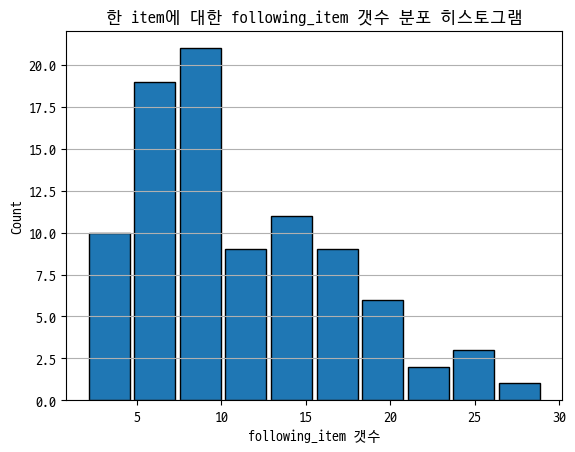

In [72]:
plot_histogram(input_var_col = df_pairs['size'] , num_bin = 10,
                title_str = "한 item에 대한 following_item 갯수 분포 히스토그램",
                xlbl_str = 'following_item 갯수',
                verbose = False)

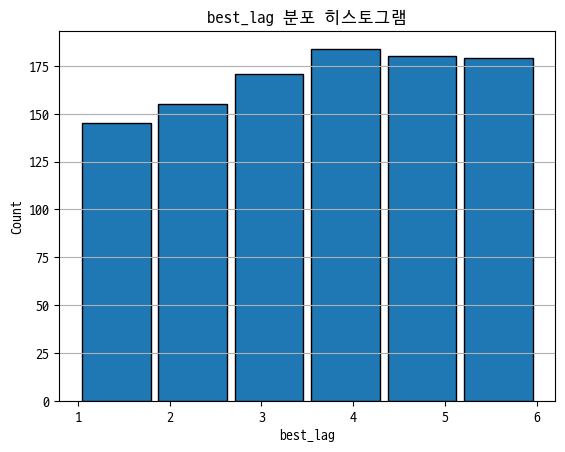

In [74]:
plot_histogram(input_var_col = pairs['best_lag'] , num_bin = 6,
                title_str = "best_lag 분포 히스토그램",
                xlbl_str = 'best_lag',
                verbose = False)

In [75]:
##### answer_df 생성
display(pairs.head(3))
answer_df = pairs[['leading_item_id', 'following_item_id']].copy()

display(answer_df)
answer_df['value'] = answer_df['following_item_id'].apply(lambda x: dct_y_true[x])
answer_df.head()

,leading_item_id,following_item_id,best_lag,max_corr,max_corr_abs
0,AANGBULD,DEWLVASR,6,0.483517,0.483517
1,AANGBULD,FTSVTTSR,3,0.437522,0.437522
2,AANGBULD,GKQIJYDH,5,-0.433616,0.433616


,leading_item_id,following_item_id
0,AANGBULD,DEWLVASR
1,AANGBULD,FTSVTTSR
2,AANGBULD,GKQIJYDH
3,AANGBULD,LTOYKIML
4,AANGBULD,NAQIHUKZ
...,...,...
1009,ZXERAXWP,MIRCVAMV
1010,ZXERAXWP,UIFPPCLR
1011,ZXERAXWP,VBYCLTYZ
1012,ZXERAXWP,WHPUAOID


,leading_item_id,following_item_id,value
0,AANGBULD,DEWLVASR,482787.0
1,AANGBULD,FTSVTTSR,246916.0
2,AANGBULD,GKQIJYDH,11621444.0
3,AANGBULD,LTOYKIML,590850.0
4,AANGBULD,NAQIHUKZ,0.0


In [76]:
for gn, gdf in answer_df.groupby('following_item_id'):
    print("group name: ", gn)
    print("group dataframe: \n", gdf)
    break

group name:  AANGBULD
group dataframe: 
     leading_item_id following_item_id     value
200        ELQGMQWE          AANGBULD  533478.0
414        KAGJCHMR          AANGBULD  533478.0
439        LLHREMKS          AANGBULD  533478.0
902        WPQXWHYO          AANGBULD  533478.0


In [77]:
pairs.head()

,leading_item_id,following_item_id,best_lag,max_corr,max_corr_abs
0,AANGBULD,DEWLVASR,6,0.483517,0.483517
1,AANGBULD,FTSVTTSR,3,0.437522,0.437522
2,AANGBULD,GKQIJYDH,5,-0.433616,0.433616
3,AANGBULD,LTOYKIML,1,0.449866,0.449866
4,AANGBULD,NAQIHUKZ,2,0.464581,0.464581


In [78]:
#####
##### Feature Engineering 변수 추가
#####

# Engineered Feature 를 pairs에 추가:  위에서 feat. eng. 한 범주화 변수 추가 ()
pairs['wv_cat'] = pairs['following_item_id'].map(dct_wv_cat) # following_item_id 에 대한 추론을 할 것이므로
pairs.head(3)

,leading_item_id,following_item_id,best_lag,max_corr,max_corr_abs,wv_cat
0,AANGBULD,DEWLVASR,6,0.483517,0.483517,4
1,AANGBULD,FTSVTTSR,3,0.437522,0.437522,4
2,AANGBULD,GKQIJYDH,5,-0.433616,0.433616,4


In [80]:
# Engineered Feature 를 pairs에 추가:  위에서 feat. eng. 한 범주화 변수 추가 ()
pairs['seq_cat'] = pairs['following_item_id'].map(dct_seq_cat) # following_item_id 에 대한 추론을 할 것이므로
pairs.head(3)

,leading_item_id,following_item_id,best_lag,max_corr,max_corr_abs,wv_cat,seq_cat
0,AANGBULD,DEWLVASR,6,0.483517,0.483517,4,3
1,AANGBULD,FTSVTTSR,3,0.437522,0.437522,4,3
2,AANGBULD,GKQIJYDH,5,-0.433616,0.433616,4,3


In [82]:
# Engineered Feature 를 pairs에 추가:  위에서 feat. eng. 한 범주화 변수 추가 ()
pairs['hs4_cat'] = pairs['following_item_id'].map(dct_hs4_cat) # following_item_id 에 대한 추론을 할 것이므로
pairs.head(3)

,leading_item_id,following_item_id,best_lag,max_corr,max_corr_abs,wv_cat,seq_cat,hs4_cat
0,AANGBULD,DEWLVASR,6,0.483517,0.483517,4,3,14
1,AANGBULD,FTSVTTSR,3,0.437522,0.437522,4,3,12
2,AANGBULD,GKQIJYDH,5,-0.433616,0.433616,4,3,3


## 4. ML 모델 학습 + 5. 회귀 모델 추론
- 시계열 데이터 안에서 '한 달 뒤 총 무역량(value)을 맞추는 문제'로 self-supervised 학습
- 탐색된 모든 공행성쌍 (A,B)에 대해 월 t마다 학습 샘플 생성
- input X:
1) B_t (현재 총 무역량(value))
2) B_{t-1} (직전 달 총 무역량(value))
3) A_{t-lag} (lag 반영된 총 무역량(value))
4) max_corr, best_lag (관계 특성)

+ engineered features:
5) weight-value cat.

- target y:
1) B_{t+1} (다음 달 총 무역량(value))
- 이러한 모든 샘플을 합쳐 LinearRegression 회귀 모델을 학습

In [84]:
##########
########## 모델 학습 Step1: 일단 정해진 기본값 파라미터에서 성능을 확인 
##########

### sklearn GBT
from sklearn import datasets, ensemble

### 1) 학습 데이터 생성
df_train_model = build_training_data_fe(pivot, pairs, add_fe=['wv_cat', 'seq_cat', 'hs4_cat']) # 생성된 학습 데이터의 shape : (53318, 9)

print('생성된 학습 데이터의 shape :', df_train_model.shape)
display(df_train_model.head())
EXP_LOG['생성된 학습 데이터의 shape'] = df_train_model.shape

### 2) X, y 준비
feature_cols = ['b_t', 'b_t_1', 'a_t_lag', 'max_corr', 'best_lag', 'wv_cat', 'seq_cat', 'hs4_cat']

train_X = df_train_model[feature_cols].values
train_y = df_train_model["target"].values


### 3) 모델 준비 및 학습
mdl = ensemble.GradientBoostingRegressor(random_state=42)
mdl.fit(train_X, train_y)

print(mdl.get_params())


### 4) 추론
y_pred = predict_fe(pivot, pairs, mdl, add_fe=['wv_cat', 'seq_cat','hs4_cat'])


### 5) Local test score
#comovement_score(answer_df, submission_df)
#y_true = target_pivot.copy() #  target_pivot.shape = (100, 1)
y_true = answer_df

local_exp_score = comovement_score(y_true , y_pred) #  y_pred.shape = (1425, 3)
print(float(local_exp_score)) # 0.7670925863654553 (baseline) -> 0.7750724995354716 (wv_cat) 
                            # -> 0.7804210526638351 (seq_cat) -> 0.7833437474190103 (hs4_cat)
EXP_LOG['local_exp_score'] = float(local_exp_score)


생성된 학습 데이터의 shape : (37896, 9)


,b_t,b_t_1,a_t_lag,max_corr,best_lag,wv_cat,seq_cat,hs4_cat,target
0,104852.0,313372.0,14276.0,0.483517,6.0,4.0,3.0,14.0,246652.0
1,246652.0,104852.0,52347.0,0.483517,6.0,4.0,3.0,14.0,103737.0
2,103737.0,246652.0,53549.0,0.483517,6.0,4.0,3.0,14.0,0.0
3,0.0,103737.0,0.0,0.483517,6.0,4.0,3.0,14.0,185367.0
4,185367.0,0.0,26997.0,0.483517,6.0,4.0,3.0,14.0,236201.0


{'alpha': 0.9, 'ccp_alpha': 0.0, 'criterion': 'friedman_mse', 'init': None, 'learning_rate': 0.1, 'loss': 'squared_error', 'max_depth': 3, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_iter_no_change': None, 'random_state': 42, 'subsample': 1.0, 'tol': 0.0001, 'validation_fraction': 0.1, 'verbose': 0, 'warm_start': False}


1014it [00:00, 2219.53it/s]

########################################
S1: comovement_f1(answer_df, submission_df): 1.0
S2: 1 - comovement_nmae(answer_df, submission_df, 1e-6): 0.4163545909516688
score(=0.6*S1 + 0.4*S2): 0.7665418363806675
0.7665418363806675


### Hyperparameter optimization: optuna
- https://optuna.org/#code_examples
- https://github.com/optuna/optuna-examples/tree/main
- https://optuna.readthedocs.io/en/stable/faq.html
- https://velog.io/@newnew_daddy/data02


In [86]:
import optuna

import sklearn.datasets
import sklearn.ensemble
import sklearn.svm


y_true = answer_df
X, y = train_X.copy(), train_y.copy()
n_features = len(feature_cols)
n_features_sqrt = int(np.sqrt(n_features))

# FYI: Objective functions can take additional arguments
# (https://optuna.readthedocs.io/en/stable/faq.html#objective-func-additional-args).
def objective(trial):

    gbt_max_depth = trial.suggest_int("gbt_max_depth", 2, 32, log=True)
    gbt_learning_rate = trial.suggest_float("gbt_learning_rate", 10**-3, 10**0, log=True)
    gbt_max_features = trial.suggest_int("gbt_max_features", n_features_sqrt, n_features, log=False)
    gbt_min_samples_split = trial.suggest_int("gbt_min_samples_split", 2, 10, log=False)
    gbt_min_samples_leaf = trial.suggest_int("gbt_min_samples_leaf", 1, 10, log=False)
    gbt_n_estimators = trial.suggest_int("gbt_n_estimators", 10, 2000, log=True)

    classifier_obj = sklearn.ensemble.GradientBoostingRegressor(
        max_depth=gbt_max_depth, 
        learning_rate = gbt_learning_rate,
        max_features = gbt_max_features,
        min_samples_split = gbt_min_samples_split,
        min_samples_leaf = gbt_min_samples_leaf,
        n_estimators=gbt_n_estimators,
        random_state = 42
    )

    classifier_obj.fit(X, y)
    y_pred = predict_fe(pivot, pairs, classifier_obj, add_fe=['wv_cat', 'seq_cat','hs4_cat'])
    score = float(comovement_score(y_true , y_pred))  # 1- score: for score maximization
    return score


study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=50)
print(study.best_trial)
EXP_LOG['optuna Best Study'] = study.best_trial

[I 2025-11-23 17:39:26,471] A new study created in memory with name: no-name-674a54b4-e65a-4b2c-aeb8-c503fb06e6b8
1014it [00:01, 821.38it/s]
[I 2025-11-23 17:42:16,663] Trial 0 finished with value: 0.790073240653226 and parameters: {'gbt_max_depth': 21, 'gbt_learning_rate': 0.06510127615478666, 'gbt_max_features': 5, 'gbt_min_samples_split': 6, 'gbt_min_samples_leaf': 2, 'gbt_n_estimators': 772}. Best is trial 0 with value: 0.790073240653226.


########################################
S1: comovement_f1(answer_df, submission_df): 1.0
S2: 1 - comovement_nmae(answer_df, submission_df, 1e-6): 0.4751831016330652
score(=0.6*S1 + 0.4*S2): 0.790073240653226


1014it [00:00, 1841.95it/s]
[I 2025-11-23 17:42:25,026] Trial 1 finished with value: 0.7727170685868849 and parameters: {'gbt_max_depth': 2, 'gbt_learning_rate': 0.18970593377235678, 'gbt_max_features': 6, 'gbt_min_samples_split': 6, 'gbt_min_samples_leaf': 8, 'gbt_n_estimators': 318}. Best is trial 0 with value: 0.790073240653226.


########################################
S1: comovement_f1(answer_df, submission_df): 1.0
S2: 1 - comovement_nmae(answer_df, submission_df, 1e-6): 0.43179267146721234
score(=0.6*S1 + 0.4*S2): 0.7727170685868849


1014it [00:01, 781.78it/s]
[I 2025-11-23 17:46:37,346] Trial 2 finished with value: 0.7700878830631186 and parameters: {'gbt_max_depth': 27, 'gbt_learning_rate': 0.4994139844610608, 'gbt_max_features': 7, 'gbt_min_samples_split': 6, 'gbt_min_samples_leaf': 6, 'gbt_n_estimators': 656}. Best is trial 0 with value: 0.790073240653226.


########################################
S1: comovement_f1(answer_df, submission_df): 1.0
S2: 1 - comovement_nmae(answer_df, submission_df, 1e-6): 0.4252197076577965
score(=0.6*S1 + 0.4*S2): 0.7700878830631186


1014it [00:00, 2601.34it/s]
[I 2025-11-23 17:46:38,347] Trial 3 finished with value: 0.6536981841650772 and parameters: {'gbt_max_depth': 4, 'gbt_learning_rate': 0.0020064830208569536, 'gbt_max_features': 5, 'gbt_min_samples_split': 7, 'gbt_min_samples_leaf': 8, 'gbt_n_estimators': 14}. Best is trial 0 with value: 0.790073240653226.


########################################
S1: comovement_f1(answer_df, submission_df): 1.0
S2: 1 - comovement_nmae(answer_df, submission_df, 1e-6): 0.13424546041269303
score(=0.6*S1 + 0.4*S2): 0.6536981841650772


1014it [00:00, 2389.17it/s]
[I 2025-11-23 17:46:40,568] Trial 4 finished with value: 0.6574037474289315 and parameters: {'gbt_max_depth': 2, 'gbt_learning_rate': 0.0034034078743031145, 'gbt_max_features': 7, 'gbt_min_samples_split': 3, 'gbt_min_samples_leaf': 10, 'gbt_n_estimators': 61}. Best is trial 0 with value: 0.790073240653226.


########################################
S1: comovement_f1(answer_df, submission_df): 1.0
S2: 1 - comovement_nmae(answer_df, submission_df, 1e-6): 0.14350936857232877
score(=0.6*S1 + 0.4*S2): 0.6574037474289315


1014it [00:00, 2535.82it/s]
[I 2025-11-23 17:46:41,710] Trial 5 finished with value: 0.6566035713333114 and parameters: {'gbt_max_depth': 11, 'gbt_learning_rate': 0.010327892712003909, 'gbt_max_features': 2, 'gbt_min_samples_split': 7, 'gbt_min_samples_leaf': 7, 'gbt_n_estimators': 14}. Best is trial 0 with value: 0.790073240653226.


########################################
S1: comovement_f1(answer_df, submission_df): 1.0
S2: 1 - comovement_nmae(answer_df, submission_df, 1e-6): 0.14150892833327855
score(=0.6*S1 + 0.4*S2): 0.6566035713333114


1014it [00:00, 1556.99it/s]
[I 2025-11-23 17:47:15,029] Trial 6 finished with value: 0.7281085722163267 and parameters: {'gbt_max_depth': 5, 'gbt_learning_rate': 0.00564213106216177, 'gbt_max_features': 8, 'gbt_min_samples_split': 5, 'gbt_min_samples_leaf': 10, 'gbt_n_estimators': 404}. Best is trial 0 with value: 0.790073240653226.


########################################
S1: comovement_f1(answer_df, submission_df): 1.0
S2: 1 - comovement_nmae(answer_df, submission_df, 1e-6): 0.32027143054081686
score(=0.6*S1 + 0.4*S2): 0.7281085722163267


1014it [00:00, 1776.97it/s]
[I 2025-11-23 17:47:27,200] Trial 7 finished with value: 0.7445029683687282 and parameters: {'gbt_max_depth': 14, 'gbt_learning_rate': 0.021545266237436602, 'gbt_max_features': 3, 'gbt_min_samples_split': 7, 'gbt_min_samples_leaf': 4, 'gbt_n_estimators': 132}. Best is trial 0 with value: 0.790073240653226.


########################################
S1: comovement_f1(answer_df, submission_df): 1.0
S2: 1 - comovement_nmae(answer_df, submission_df, 1e-6): 0.36125742092182056
score(=0.6*S1 + 0.4*S2): 0.7445029683687282


1014it [00:01, 735.54it/s]
[I 2025-11-23 17:48:16,957] Trial 8 finished with value: 0.8002879908571384 and parameters: {'gbt_max_depth': 14, 'gbt_learning_rate': 0.06442914992271657, 'gbt_max_features': 2, 'gbt_min_samples_split': 4, 'gbt_min_samples_leaf': 1, 'gbt_n_estimators': 726}. Best is trial 8 with value: 0.8002879908571384.


########################################
S1: comovement_f1(answer_df, submission_df): 1.0
S2: 1 - comovement_nmae(answer_df, submission_df, 1e-6): 0.5007199771428461
score(=0.6*S1 + 0.4*S2): 0.8002879908571384


1014it [00:00, 2096.32it/s]
[I 2025-11-23 17:48:21,513] Trial 9 finished with value: 0.6594796830209602 and parameters: {'gbt_max_depth': 23, 'gbt_learning_rate': 0.004993830480846763, 'gbt_max_features': 2, 'gbt_min_samples_split': 6, 'gbt_min_samples_leaf': 5, 'gbt_n_estimators': 45}. Best is trial 8 with value: 0.8002879908571384.


########################################
S1: comovement_f1(answer_df, submission_df): 1.0
S2: 1 - comovement_nmae(answer_df, submission_df, 1e-6): 0.14869920755240051
score(=0.6*S1 + 0.4*S2): 0.6594796830209602


1014it [00:00, 1865.32it/s]
[I 2025-11-23 17:48:34,370] Trial 10 finished with value: 0.791207326867243 and parameters: {'gbt_max_depth': 9, 'gbt_learning_rate': 0.05928431912457609, 'gbt_max_features': 4, 'gbt_min_samples_split': 10, 'gbt_min_samples_leaf': 1, 'gbt_n_estimators': 165}. Best is trial 8 with value: 0.8002879908571384.


########################################
S1: comovement_f1(answer_df, submission_df): 1.0
S2: 1 - comovement_nmae(answer_df, submission_df, 1e-6): 0.4780183171681077
score(=0.6*S1 + 0.4*S2): 0.791207326867243


1014it [00:01, 652.46it/s]
[I 2025-11-23 17:50:19,554] Trial 11 finished with value: 0.7865388354522627 and parameters: {'gbt_max_depth': 9, 'gbt_learning_rate': 0.07352514808857179, 'gbt_max_features': 4, 'gbt_min_samples_split': 9, 'gbt_min_samples_leaf': 1, 'gbt_n_estimators': 1368}. Best is trial 8 with value: 0.8002879908571384.


########################################
S1: comovement_f1(answer_df, submission_df): 1.0
S2: 1 - comovement_nmae(answer_df, submission_df, 1e-6): 0.46634708863065677
score(=0.6*S1 + 0.4*S2): 0.7865388354522627


1014it [00:00, 1950.88it/s]
[I 2025-11-23 17:50:28,795] Trial 12 finished with value: 0.786217180917032 and parameters: {'gbt_max_depth': 7, 'gbt_learning_rate': 0.18344630369629703, 'gbt_max_features': 3, 'gbt_min_samples_split': 10, 'gbt_min_samples_leaf': 3, 'gbt_n_estimators': 193}. Best is trial 8 with value: 0.8002879908571384.


########################################
S1: comovement_f1(answer_df, submission_df): 1.0
S2: 1 - comovement_nmae(answer_df, submission_df, 1e-6): 0.4655429522925799
score(=0.6*S1 + 0.4*S2): 0.786217180917032


1014it [00:00, 2015.41it/s]
[I 2025-11-23 17:50:41,762] Trial 13 finished with value: 0.7572009999275426 and parameters: {'gbt_max_depth': 15, 'gbt_learning_rate': 0.03183046106588335, 'gbt_max_features': 4, 'gbt_min_samples_split': 3, 'gbt_min_samples_leaf': 1, 'gbt_n_estimators': 99}. Best is trial 8 with value: 0.8002879908571384.


########################################
S1: comovement_f1(answer_df, submission_df): 1.0
S2: 1 - comovement_nmae(answer_df, submission_df, 1e-6): 0.3930024998188565
score(=0.6*S1 + 0.4*S2): 0.7572009999275426


1014it [00:01, 698.90it/s]
[I 2025-11-23 17:51:26,129] Trial 14 finished with value: 0.781392058357858 and parameters: {'gbt_max_depth': 4, 'gbt_learning_rate': 0.8011500694625037, 'gbt_max_features': 3, 'gbt_min_samples_split': 2, 'gbt_min_samples_leaf': 3, 'gbt_n_estimators': 1617}. Best is trial 8 with value: 0.8002879908571384.


########################################
S1: comovement_f1(answer_df, submission_df): 1.0
S2: 1 - comovement_nmae(answer_df, submission_df, 1e-6): 0.4534801458946449
score(=0.6*S1 + 0.4*S2): 0.781392058357858


1014it [00:00, 1689.05it/s]
[I 2025-11-23 17:51:42,496] Trial 15 finished with value: 0.783250840085937 and parameters: {'gbt_max_depth': 7, 'gbt_learning_rate': 0.14831162674134818, 'gbt_max_features': 4, 'gbt_min_samples_split': 4, 'gbt_min_samples_leaf': 1, 'gbt_n_estimators': 267}. Best is trial 8 with value: 0.8002879908571384.


########################################
S1: comovement_f1(answer_df, submission_df): 1.0
S2: 1 - comovement_nmae(answer_df, submission_df, 1e-6): 0.4581271002148426
score(=0.6*S1 + 0.4*S2): 0.783250840085937


1014it [00:00, 2414.24it/s]
[I 2025-11-23 17:51:45,350] Trial 16 finished with value: 0.6777679531492998 and parameters: {'gbt_max_depth': 15, 'gbt_learning_rate': 0.022533006444887916, 'gbt_max_features': 2, 'gbt_min_samples_split': 9, 'gbt_min_samples_leaf': 3, 'gbt_n_estimators': 35}. Best is trial 8 with value: 0.8002879908571384.


########################################
S1: comovement_f1(answer_df, submission_df): 1.0
S2: 1 - comovement_nmae(answer_df, submission_df, 1e-6): 0.19441988287324963
score(=0.6*S1 + 0.4*S2): 0.6777679531492998


1014it [00:00, 1028.54it/s]
[I 2025-11-23 17:52:28,783] Trial 17 finished with value: 0.6764651168771398 and parameters: {'gbt_max_depth': 10, 'gbt_learning_rate': 0.0010666297413992115, 'gbt_max_features': 3, 'gbt_min_samples_split': 10, 'gbt_min_samples_leaf': 2, 'gbt_n_estimators': 681}. Best is trial 8 with value: 0.8002879908571384.


########################################
S1: comovement_f1(answer_df, submission_df): 1.0
S2: 1 - comovement_nmae(answer_df, submission_df, 1e-6): 0.19116279219284948
score(=0.6*S1 + 0.4*S2): 0.6764651168771398


1014it [00:00, 2337.47it/s]
[I 2025-11-23 17:52:32,438] Trial 18 finished with value: 0.7605300506546034 and parameters: {'gbt_max_depth': 3, 'gbt_learning_rate': 0.06000944147125409, 'gbt_max_features': 6, 'gbt_min_samples_split': 4, 'gbt_min_samples_leaf': 5, 'gbt_n_estimators': 88}. Best is trial 8 with value: 0.8002879908571384.


########################################
S1: comovement_f1(answer_df, submission_df): 1.0
S2: 1 - comovement_nmae(answer_df, submission_df, 1e-6): 0.40132512663650866
score(=0.6*S1 + 0.4*S2): 0.7605300506546034


1014it [00:01, 622.29it/s]
[I 2025-11-23 17:55:15,404] Trial 19 finished with value: 0.7700637616331676 and parameters: {'gbt_max_depth': 19, 'gbt_learning_rate': 0.3741241869204459, 'gbt_max_features': 4, 'gbt_min_samples_split': 8, 'gbt_min_samples_leaf': 2, 'gbt_n_estimators': 1012}. Best is trial 8 with value: 0.8002879908571384.


########################################
S1: comovement_f1(answer_df, submission_df): 1.0
S2: 1 - comovement_nmae(answer_df, submission_df, 1e-6): 0.42515940408291886
score(=0.6*S1 + 0.4*S2): 0.7700637616331676


1014it [00:00, 2415.60it/s]
[I 2025-11-23 17:55:21,284] Trial 20 finished with value: 0.6626310522272068 and parameters: {'gbt_max_depth': 29, 'gbt_learning_rate': 0.011184407297393352, 'gbt_max_features': 5, 'gbt_min_samples_split': 4, 'gbt_min_samples_leaf': 4, 'gbt_n_estimators': 26}. Best is trial 8 with value: 0.8002879908571384.


########################################
S1: comovement_f1(answer_df, submission_df): 1.0
S2: 1 - comovement_nmae(answer_df, submission_df, 1e-6): 0.156577630568017
score(=0.6*S1 + 0.4*S2): 0.6626310522272068


1014it [00:00, 1062.51it/s]
[I 2025-11-23 17:57:14,063] Trial 21 finished with value: 0.7889111415499384 and parameters: {'gbt_max_depth': 18, 'gbt_learning_rate': 0.07023121904355834, 'gbt_max_features': 6, 'gbt_min_samples_split': 5, 'gbt_min_samples_leaf': 2, 'gbt_n_estimators': 521}. Best is trial 8 with value: 0.8002879908571384.


########################################
S1: comovement_f1(answer_df, submission_df): 1.0
S2: 1 - comovement_nmae(answer_df, submission_df, 1e-6): 0.4722778538748459
score(=0.6*S1 + 0.4*S2): 0.7889111415499384


1014it [00:01, 848.14it/s]
[I 2025-11-23 17:59:08,531] Trial 22 finished with value: 0.7785440038582209 and parameters: {'gbt_max_depth': 12, 'gbt_learning_rate': 0.04423597202323465, 'gbt_max_features': 5, 'gbt_min_samples_split': 5, 'gbt_min_samples_leaf': 1, 'gbt_n_estimators': 929}. Best is trial 8 with value: 0.8002879908571384.


########################################
S1: comovement_f1(answer_df, submission_df): 1.0
S2: 1 - comovement_nmae(answer_df, submission_df, 1e-6): 0.4463600096455522
score(=0.6*S1 + 0.4*S2): 0.7785440038582209


1014it [00:00, 1649.73it/s]
[I 2025-11-23 17:59:47,572] Trial 23 finished with value: 0.7835349214143625 and parameters: {'gbt_max_depth': 19, 'gbt_learning_rate': 0.12032932622171119, 'gbt_max_features': 5, 'gbt_min_samples_split': 8, 'gbt_min_samples_leaf': 2, 'gbt_n_estimators': 201}. Best is trial 8 with value: 0.8002879908571384.


########################################
S1: comovement_f1(answer_df, submission_df): 1.0
S2: 1 - comovement_nmae(answer_df, submission_df, 1e-6): 0.45883730353590624
score(=0.6*S1 + 0.4*S2): 0.7835349214143625


1014it [00:01, 537.88it/s]
[I 2025-11-23 18:02:14,301] Trial 24 finished with value: 0.7957787967137401 and parameters: {'gbt_max_depth': 9, 'gbt_learning_rate': 0.09773740756974413, 'gbt_max_features': 4, 'gbt_min_samples_split': 2, 'gbt_min_samples_leaf': 1, 'gbt_n_estimators': 1922}. Best is trial 8 with value: 0.8002879908571384.


########################################
S1: comovement_f1(answer_df, submission_df): 1.0
S2: 1 - comovement_nmae(answer_df, submission_df, 1e-6): 0.48944699178435025
score(=0.6*S1 + 0.4*S2): 0.7957787967137401


1014it [00:02, 477.41it/s]
[I 2025-11-23 18:04:12,943] Trial 25 finished with value: 0.7819576869827616 and parameters: {'gbt_max_depth': 9, 'gbt_learning_rate': 0.377571685263757, 'gbt_max_features': 3, 'gbt_min_samples_split': 2, 'gbt_min_samples_leaf': 1, 'gbt_n_estimators': 1960}. Best is trial 8 with value: 0.8002879908571384.


########################################
S1: comovement_f1(answer_df, submission_df): 1.0
S2: 1 - comovement_nmae(answer_df, submission_df, 1e-6): 0.45489421745690395
score(=0.6*S1 + 0.4*S2): 0.7819576869827616


1014it [00:01, 925.60it/s]
[I 2025-11-23 18:05:03,109] Trial 26 finished with value: 0.7920006238538515 and parameters: {'gbt_max_depth': 5, 'gbt_learning_rate': 0.10388261378293948, 'gbt_max_features': 4, 'gbt_min_samples_split': 3, 'gbt_min_samples_leaf': 4, 'gbt_n_estimators': 1172}. Best is trial 8 with value: 0.8002879908571384.


########################################
S1: comovement_f1(answer_df, submission_df): 1.0
S2: 1 - comovement_nmae(answer_df, submission_df, 1e-6): 0.48000155963462876
score(=0.6*S1 + 0.4*S2): 0.7920006238538515


1014it [00:01, 871.30it/s]
[I 2025-11-23 18:05:33,342] Trial 27 finished with value: 0.785987138874782 and parameters: {'gbt_max_depth': 5, 'gbt_learning_rate': 0.12847832701166084, 'gbt_max_features': 2, 'gbt_min_samples_split': 3, 'gbt_min_samples_leaf': 4, 'gbt_n_estimators': 1263}. Best is trial 8 with value: 0.8002879908571384.


########################################
S1: comovement_f1(answer_df, submission_df): 1.0
S2: 1 - comovement_nmae(answer_df, submission_df, 1e-6): 0.46496784718695505
score(=0.6*S1 + 0.4*S2): 0.785987138874782


1014it [00:01, 625.44it/s]
[I 2025-11-23 18:06:49,766] Trial 28 finished with value: 0.7849853447436019 and parameters: {'gbt_max_depth': 6, 'gbt_learning_rate': 0.26033678484943784, 'gbt_max_features': 3, 'gbt_min_samples_split': 2, 'gbt_min_samples_leaf': 6, 'gbt_n_estimators': 1949}. Best is trial 8 with value: 0.8002879908571384.


########################################
S1: comovement_f1(answer_df, submission_df): 1.0
S2: 1 - comovement_nmae(answer_df, submission_df, 1e-6): 0.46246336185900483
score(=0.6*S1 + 0.4*S2): 0.7849853447436019


1014it [00:00, 1166.19it/s]
[I 2025-11-23 18:07:13,173] Trial 29 finished with value: 0.7895577680526215 and parameters: {'gbt_max_depth': 3, 'gbt_learning_rate': 0.09554941572256209, 'gbt_max_features': 4, 'gbt_min_samples_split': 3, 'gbt_min_samples_leaf': 3, 'gbt_n_estimators': 898}. Best is trial 8 with value: 0.8002879908571384.


########################################
S1: comovement_f1(answer_df, submission_df): 1.0
S2: 1 - comovement_nmae(answer_df, submission_df, 1e-6): 0.4738944201315536
score(=0.6*S1 + 0.4*S2): 0.7895577680526215


1014it [00:00, 1521.03it/s]
[I 2025-11-23 18:07:24,957] Trial 30 finished with value: 0.7767876660698447 and parameters: {'gbt_max_depth': 6, 'gbt_learning_rate': 0.033437214390010135, 'gbt_max_features': 2, 'gbt_min_samples_split': 2, 'gbt_min_samples_leaf': 4, 'gbt_n_estimators': 425}. Best is trial 8 with value: 0.8002879908571384.


########################################
S1: comovement_f1(answer_df, submission_df): 1.0
S2: 1 - comovement_nmae(answer_df, submission_df, 1e-6): 0.44196916517461193
score(=0.6*S1 + 0.4*S2): 0.7767876660698447


1014it [00:01, 704.43it/s]
[I 2025-11-23 18:09:28,664] Trial 31 finished with value: 0.7839753131647047 and parameters: {'gbt_max_depth': 12, 'gbt_learning_rate': 0.0481629218575742, 'gbt_max_features': 4, 'gbt_min_samples_split': 4, 'gbt_min_samples_leaf': 2, 'gbt_n_estimators': 1236}. Best is trial 8 with value: 0.8002879908571384.


########################################
S1: comovement_f1(answer_df, submission_df): 1.0
S2: 1 - comovement_nmae(answer_df, submission_df, 1e-6): 0.45993828291176186
score(=0.6*S1 + 0.4*S2): 0.7839753131647047


1014it [00:00, 1272.46it/s]
[I 2025-11-23 18:10:18,285] Trial 32 finished with value: 0.7871708148921209 and parameters: {'gbt_max_depth': 8, 'gbt_learning_rate': 0.017540090407415686, 'gbt_max_features': 5, 'gbt_min_samples_split': 3, 'gbt_min_samples_leaf': 1, 'gbt_n_estimators': 614}. Best is trial 8 with value: 0.8002879908571384.


########################################
S1: comovement_f1(answer_df, submission_df): 1.0
S2: 1 - comovement_nmae(answer_df, submission_df, 1e-6): 0.4679270372303024
score(=0.6*S1 + 0.4*S2): 0.7871708148921209


1014it [00:00, 1537.63it/s]
[I 2025-11-23 18:10:45,930] Trial 33 finished with value: 0.7930533862490979 and parameters: {'gbt_max_depth': 9, 'gbt_learning_rate': 0.09588858177705438, 'gbt_max_features': 4, 'gbt_min_samples_split': 2, 'gbt_min_samples_leaf': 2, 'gbt_n_estimators': 366}. Best is trial 8 with value: 0.8002879908571384.


########################################
S1: comovement_f1(answer_df, submission_df): 1.0
S2: 1 - comovement_nmae(answer_df, submission_df, 1e-6): 0.4826334656227449
score(=0.6*S1 + 0.4*S2): 0.7930533862490979


1014it [00:00, 1715.52it/s]
[I 2025-11-23 18:11:05,464] Trial 34 finished with value: 0.790822336726146 and parameters: {'gbt_max_depth': 5, 'gbt_learning_rate': 0.23965960970878863, 'gbt_max_features': 6, 'gbt_min_samples_split': 2, 'gbt_min_samples_leaf': 3, 'gbt_n_estimators': 315}. Best is trial 8 with value: 0.8002879908571384.


########################################
S1: comovement_f1(answer_df, submission_df): 1.0
S2: 1 - comovement_nmae(answer_df, submission_df, 1e-6): 0.47705584181536487
score(=0.6*S1 + 0.4*S2): 0.790822336726146


1014it [00:00, 1201.96it/s]
[I 2025-11-23 18:11:25,345] Trial 35 finished with value: 0.785687519023095 and parameters: {'gbt_max_depth': 4, 'gbt_learning_rate': 0.09231157057445044, 'gbt_max_features': 3, 'gbt_min_samples_split': 3, 'gbt_min_samples_leaf': 2, 'gbt_n_estimators': 753}. Best is trial 8 with value: 0.8002879908571384.


########################################
S1: comovement_f1(answer_df, submission_df): 1.0
S2: 1 - comovement_nmae(answer_df, submission_df, 1e-6): 0.46421879755773743
score(=0.6*S1 + 0.4*S2): 0.785687519023095


1014it [00:00, 1540.07it/s]
[I 2025-11-23 18:11:45,499] Trial 36 finished with value: 0.7876700004397466 and parameters: {'gbt_max_depth': 3, 'gbt_learning_rate': 0.697328200886135, 'gbt_max_features': 7, 'gbt_min_samples_split': 2, 'gbt_min_samples_leaf': 5, 'gbt_n_estimators': 464}. Best is trial 8 with value: 0.8002879908571384.


########################################
S1: comovement_f1(answer_df, submission_df): 1.0
S2: 1 - comovement_nmae(answer_df, submission_df, 1e-6): 0.4691750010993663
score(=0.6*S1 + 0.4*S2): 0.7876700004397466


1014it [00:01, 733.29it/s]
[I 2025-11-23 18:13:45,217] Trial 37 finished with value: 0.7859101087031171 and parameters: {'gbt_max_depth': 13, 'gbt_learning_rate': 0.19764594509438452, 'gbt_max_features': 4, 'gbt_min_samples_split': 3, 'gbt_min_samples_leaf': 3, 'gbt_n_estimators': 1078}. Best is trial 8 with value: 0.8002879908571384.


########################################
S1: comovement_f1(answer_df, submission_df): 1.0
S2: 1 - comovement_nmae(answer_df, submission_df, 1e-6): 0.46477527175779276
score(=0.6*S1 + 0.4*S2): 0.7859101087031171


1014it [00:00, 1437.15it/s]
[I 2025-11-23 18:15:08,115] Trial 38 finished with value: 0.7810189408767552 and parameters: {'gbt_max_depth': 24, 'gbt_learning_rate': 0.09392477381960299, 'gbt_max_features': 6, 'gbt_min_samples_split': 4, 'gbt_min_samples_leaf': 9, 'gbt_n_estimators': 305}. Best is trial 8 with value: 0.8002879908571384.


########################################
S1: comovement_f1(answer_df, submission_df): 1.0
S2: 1 - comovement_nmae(answer_df, submission_df, 1e-6): 0.4525473521918878
score(=0.6*S1 + 0.4*S2): 0.7810189408767552


1014it [00:01, 748.66it/s]
[I 2025-11-23 18:17:41,091] Trial 39 finished with value: 0.7665973009403629 and parameters: {'gbt_max_depth': 6, 'gbt_learning_rate': 0.3374563970562707, 'gbt_max_features': 8, 'gbt_min_samples_split': 5, 'gbt_min_samples_leaf': 7, 'gbt_n_estimators': 1596}. Best is trial 8 with value: 0.8002879908571384.


########################################
S1: comovement_f1(answer_df, submission_df): 1.0
S2: 1 - comovement_nmae(answer_df, submission_df, 1e-6): 0.4164932523509074
score(=0.6*S1 + 0.4*S2): 0.7665973009403629


1014it [00:00, 1220.39it/s]
[I 2025-11-23 18:18:41,716] Trial 40 finished with value: 0.7902124421978016 and parameters: {'gbt_max_depth': 11, 'gbt_learning_rate': 0.01396561015182089, 'gbt_max_features': 5, 'gbt_min_samples_split': 2, 'gbt_min_samples_leaf': 4, 'gbt_n_estimators': 547}. Best is trial 8 with value: 0.8002879908571384.


########################################
S1: comovement_f1(answer_df, submission_df): 1.0
S2: 1 - comovement_nmae(answer_df, submission_df, 1e-6): 0.47553110549450406
score(=0.6*S1 + 0.4*S2): 0.7902124421978016


1014it [00:00, 1763.14it/s]
[I 2025-11-23 18:18:59,325] Trial 41 finished with value: 0.7902506692052098 and parameters: {'gbt_max_depth': 9, 'gbt_learning_rate': 0.05022672826907559, 'gbt_max_features': 4, 'gbt_min_samples_split': 3, 'gbt_min_samples_leaf': 1, 'gbt_n_estimators': 233}. Best is trial 8 with value: 0.8002879908571384.


########################################
S1: comovement_f1(answer_df, submission_df): 1.0
S2: 1 - comovement_nmae(answer_df, submission_df, 1e-6): 0.47562667301302464
score(=0.6*S1 + 0.4*S2): 0.7902506692052098


1014it [00:00, 1945.65it/s]
[I 2025-11-23 18:19:11,922] Trial 42 finished with value: 0.7724250036902791 and parameters: {'gbt_max_depth': 10, 'gbt_learning_rate': 0.031052914258092656, 'gbt_max_features': 4, 'gbt_min_samples_split': 2, 'gbt_min_samples_leaf': 1, 'gbt_n_estimators': 148}. Best is trial 8 with value: 0.8002879908571384.


########################################
S1: comovement_f1(answer_df, submission_df): 1.0
S2: 1 - comovement_nmae(answer_df, submission_df, 1e-6): 0.43106250922569767
score(=0.6*S1 + 0.4*S2): 0.7724250036902791


1014it [00:00, 1488.18it/s]
[I 2025-11-23 18:19:30,964] Trial 43 finished with value: 0.7974678981820145 and parameters: {'gbt_max_depth': 8, 'gbt_learning_rate': 0.15050790356621271, 'gbt_max_features': 3, 'gbt_min_samples_split': 6, 'gbt_min_samples_leaf': 2, 'gbt_n_estimators': 362}. Best is trial 8 with value: 0.8002879908571384.


########################################
S1: comovement_f1(answer_df, submission_df): 1.0
S2: 1 - comovement_nmae(answer_df, submission_df, 1e-6): 0.49366974545503617
score(=0.6*S1 + 0.4*S2): 0.7974678981820145


1014it [00:00, 1491.12it/s]
[I 2025-11-23 18:19:51,260] Trial 44 finished with value: 0.7875303319719215 and parameters: {'gbt_max_depth': 8, 'gbt_learning_rate': 0.15814187153444514, 'gbt_max_features': 3, 'gbt_min_samples_split': 6, 'gbt_min_samples_leaf': 2, 'gbt_n_estimators': 387}. Best is trial 8 with value: 0.8002879908571384.


########################################
S1: comovement_f1(answer_df, submission_df): 1.0
S2: 1 - comovement_nmae(answer_df, submission_df, 1e-6): 0.4688258299298036
score(=0.6*S1 + 0.4*S2): 0.7875303319719215


1014it [00:01, 733.88it/s]
[I 2025-11-23 18:20:54,393] Trial 45 finished with value: 0.8002194390938088 and parameters: {'gbt_max_depth': 16, 'gbt_learning_rate': 0.10803269867075929, 'gbt_max_features': 2, 'gbt_min_samples_split': 7, 'gbt_min_samples_leaf': 2, 'gbt_n_estimators': 838}. Best is trial 8 with value: 0.8002879908571384.


########################################
S1: comovement_f1(answer_df, submission_df): 1.0
S2: 1 - comovement_nmae(answer_df, submission_df, 1e-6): 0.5005485977345219
score(=0.6*S1 + 0.4*S2): 0.8002194390938088


1014it [00:01, 711.25it/s]
[I 2025-11-23 18:21:57,927] Trial 46 finished with value: 0.7921640424691204 and parameters: {'gbt_max_depth': 16, 'gbt_learning_rate': 0.26086457586925665, 'gbt_max_features': 2, 'gbt_min_samples_split': 7, 'gbt_min_samples_leaf': 2, 'gbt_n_estimators': 836}. Best is trial 8 with value: 0.8002879908571384.


########################################
S1: comovement_f1(answer_df, submission_df): 1.0
S2: 1 - comovement_nmae(answer_df, submission_df, 1e-6): 0.480410106172801
score(=0.6*S1 + 0.4*S2): 0.7921640424691204


1014it [00:00, 2601.63it/s]
[I 2025-11-23 18:21:59,099] Trial 47 finished with value: 0.6787677084489099 and parameters: {'gbt_max_depth': 17, 'gbt_learning_rate': 0.07920707811257688, 'gbt_max_features': 2, 'gbt_min_samples_split': 6, 'gbt_min_samples_leaf': 2, 'gbt_n_estimators': 10}. Best is trial 8 with value: 0.8002879908571384.


########################################
S1: comovement_f1(answer_df, submission_df): 1.0
S2: 1 - comovement_nmae(answer_df, submission_df, 1e-6): 0.1969192711222748
score(=0.6*S1 + 0.4*S2): 0.6787677084489099


1014it [00:00, 1113.18it/s]
[I 2025-11-23 18:22:34,759] Trial 48 finished with value: 0.7855214473364542 and parameters: {'gbt_max_depth': 22, 'gbt_learning_rate': 0.5250838623782833, 'gbt_max_features': 2, 'gbt_min_samples_split': 8, 'gbt_min_samples_leaf': 3, 'gbt_n_estimators': 354}. Best is trial 8 with value: 0.8002879908571384.


########################################
S1: comovement_f1(answer_df, submission_df): 1.0
S2: 1 - comovement_nmae(answer_df, submission_df, 1e-6): 0.4638036183411357
score(=0.6*S1 + 0.4*S2): 0.7855214473364542


1014it [00:01, 970.09it/s]
[I 2025-11-23 18:23:36,267] Trial 49 finished with value: 0.7917751678334571 and parameters: {'gbt_max_depth': 14, 'gbt_learning_rate': 0.18247306414729347, 'gbt_max_features': 3, 'gbt_min_samples_split': 7, 'gbt_min_samples_leaf': 1, 'gbt_n_estimators': 667}. Best is trial 8 with value: 0.8002879908571384.


########################################
S1: comovement_f1(answer_df, submission_df): 1.0
S2: 1 - comovement_nmae(answer_df, submission_df, 1e-6): 0.4794379195836429
score(=0.6*S1 + 0.4*S2): 0.7917751678334571
FrozenTrial(number=8, state=<TrialState.COMPLETE: 1>, values=[0.8002879908571384], datetime_start=datetime.datetime(2025, 11, 23, 17, 47, 27, 201120), datetime_complete=datetime.datetime(2025, 11, 23, 17, 48, 16, 957890), params={'gbt_max_depth': 14, 'gbt_learning_rate': 0.06442914992271657, 'gbt_max_features': 2, 'gbt_min_samples_split': 4, 'gbt_min_samples_leaf': 1, 'gbt_n_estimators': 726}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'gbt_max_depth': IntDistribution(high=32, log=True, low=2, step=1), 'gbt_learning_rate': FloatDistribution(high=1.0, log=True, low=0.001, step=None), 'gbt_max_features': IntDistribution(high=8, log=False, low=2, step=1), 'gbt_min_samples_split': IntDistribution(high=10, log=False, low=2, step=1), 'gbt_min_samples_leaf': 

In [88]:
# local exp 설정시 로깅한 주요파라미터들 
#print(f"EXP_LOG: {EXP_LOG}")

for k,v in EXP_LOG.items():
    print(f'{k} : {v}')

min_lag : 1
max_lag : 6
min_nonzero : 12
corr_threshold : 0.4
탐색된 공행성쌍 pairs.shape : (1014, 4)
공행성이 탐지되지 않은 상품수 : 9
공행성이 탐지되지 않은 상품id: : ['ANWUJOKX', 'GIKPEWTY', 'GMBFCMIU', 'KFQSHBNH', 'PLMZALFA', 'QSDCUCLB', 'RJCAXSGH', 'RUVXNNVA', 'TANNMIMB']
공행성이 탐지된 상품수 : 91
생성된 학습 데이터의 shape : (37896, 9)
local_exp_score : 0.7665418363806675
optuna Best Study : FrozenTrial(number=8, state=<TrialState.COMPLETE: 1>, values=[0.8002879908571384], datetime_start=datetime.datetime(2025, 11, 23, 17, 47, 27, 201120), datetime_complete=datetime.datetime(2025, 11, 23, 17, 48, 16, 957890), params={'gbt_max_depth': 14, 'gbt_learning_rate': 0.06442914992271657, 'gbt_max_features': 2, 'gbt_min_samples_split': 4, 'gbt_min_samples_leaf': 1, 'gbt_n_estimators': 726}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'gbt_max_depth': IntDistribution(high=32, log=True, low=2, step=1), 'gbt_learning_rate': FloatDistribution(high=1.0, log=True, low=0.001, step=None), 'gbt_max_features': IntDistrib

In [89]:
# EXP_LOG['optuna Best Study'] = study.best_trial
## 최적의 조합 저장 객체
trial = study.best_trial

print("Value:", trial.value)
print("Params:", trial.params)
study.best_trial.params['gbt_max_depth']

Value: 0.8002879908571384
Params: {'gbt_max_depth': 14, 'gbt_learning_rate': 0.06442914992271657, 'gbt_max_features': 2, 'gbt_min_samples_split': 4, 'gbt_min_samples_leaf': 1, 'gbt_n_estimators': 726}


14

In [90]:
params_optuna = {
    "max_depth": study.best_trial.params['gbt_max_depth'],
    "learning_rate": study.best_trial.params['gbt_learning_rate'],
    "min_samples_split": study.best_trial.params['gbt_min_samples_split'],
    "min_samples_leaf": study.best_trial.params['gbt_min_samples_leaf'],
    "max_features": study.best_trial.params['gbt_max_features'],
    "n_estimators": study.best_trial.params['gbt_n_estimators'],    
    'random_state':42,
}
params_optuna

{'max_depth': 14,
 'learning_rate': 0.06442914992271657,
 'min_samples_split': 4,
 'min_samples_leaf': 1,
 'max_features': 2,
 'n_estimators': 726,
 'random_state': 42}

## 6. 평가 및 해석 
- 

In [91]:
# Import metrics.
#from sklearn.metrics import mean_squared_error, r2_score

y_actual = y_true['value']
y_predicted = y_pred['value']

# Calculate performance metrics.
r2 = r2_score(y_actual, y_predicted)
mse = mean_squared_error(y_actual, y_predicted)
rmse = np.sqrt(mse)

mape1 = local_MAPE1(y_actual, y_predicted)
mape2 = local_MAPE2(y_actual, y_predicted)
# Print evaluation metrics
print(f"R-squared: {r2:.4f}")
print(f"Mean squared error: {mse:.4f}")
print(f"Root mean squared error: {rmse:.4f}")

print(f"local testing mape1: {mape1:.4f}") # ?? NG
print(f"local testing mape2: {mape2:.4f}") # ?? NG

R-squared: 0.8841
Mean squared error: 19805438380499.0430
Root mean squared error: 4450330.1429
local testing mape1: 0.5836
local testing mape2: 21687688038688739328.0000


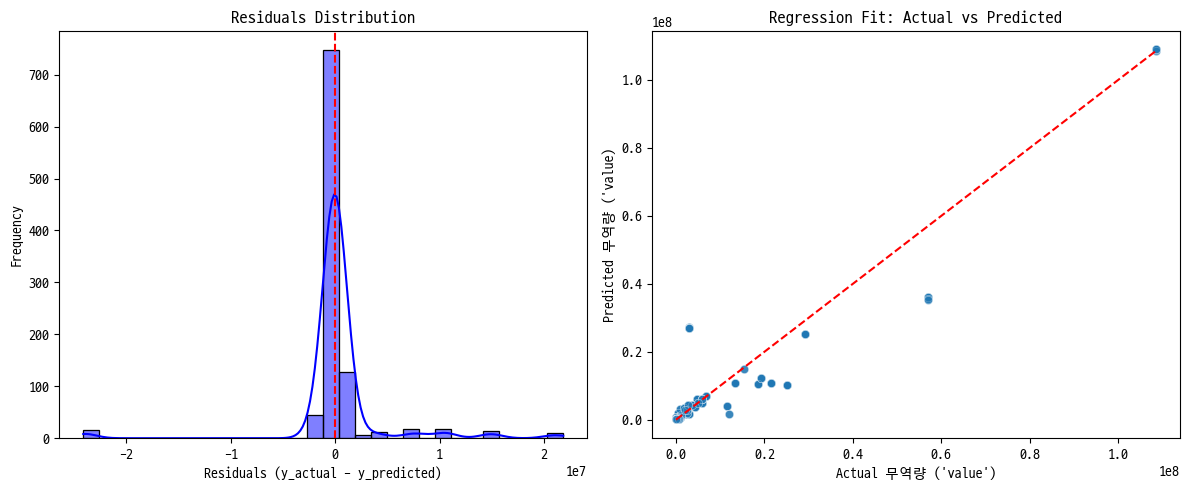

In [92]:
y_actual = y_true['value']
y_predicted = y_pred['value']

# Compute residuals.
residuals = y_actual - y_predicted


# Create plots.
plt.figure(figsize=(12,5))


# Plot 1: Residuals Distribution.
plt.subplot(1,2,1)
sns.histplot(residuals, bins=30, kde=True, color="blue")
plt.axvline(x=0, color='red', linestyle='--')
plt.title("Residuals Distribution")
plt.xlabel("Residuals (y_actual - y_predicted)")
plt.ylabel("Frequency")


# Plot 2: Regression Fit (Actual vs Predicted).
plt.subplot(1,2,2)
sns.scatterplot(x=y_actual, y=y_predicted, alpha=0.5)
plt.plot([min(y_actual), max(y_actual)], [min(y_actual), max(y_actual)], color='red', linestyle='--')  # Perfect fit line
plt.title("Regression Fit: Actual vs Predicted")
plt.xlabel("Actual 무역량 ('value')")
plt.ylabel("Predicted 무역량 ('value)")


# Show plots.
plt.tight_layout()
plt.show()

In [93]:
from optuna.visualization import (
    plot_optimization_history,
    plot_param_importances,
    plot_parallel_coordinate,
    plot_rank,
    plot_slice
)

In [ ]:
# ! pip install nbformat -q

In [ ]:
import nbformat
nbformat.__version__  # '5.10.4'


'5.10.4'

In [95]:
import plotly.io as pio
pio.renderers.default = "vscode"  # VS Code 내부 출력 (요즘 가장 안정적)
# 또는
#pio.renderers.default = "browser"  # 브라우저 출력

In [96]:
plot_optimization_history(study)

In [97]:
plot_param_importances(study)

In [98]:
plot_parallel_coordinate(study)

In [99]:
plot_rank(study)

In [100]:
plot_slice(study)


## 7. 제출 파일 만들기
- pivot을 train, test로 split했던 것을 다시 합쳐서 Feat. Eng. 한 것 추가하고 재학습하여 최종 제출 파일을 만든다. 

In [101]:
# 1) 공햏성쌍 탐색 함수 파라미터 세팅 (default: min_lag=1, max_lag=6, min_nonzero=12, corr_threshold=0.4)
min_lag=1
max_lag=6 
min_nonzero=12 
corr_threshold=0.4

# 설정파라미터 로깅
#EXP_LOG = {} # 테스트 파라미터 값 저장 딕셔너리 ==> 일단 이건 고정하고, feat.eng.와 model에 변화주며 테스팅
EXP_LOG['min_lag'] = 1
EXP_LOG['max_lag'] = 6
EXP_LOG['min_nonzero'] = 12
EXP_LOG['corr_threshold'] = 0.4

# 2) LinearRegression 모델 파라미터 세팅(defaut: )

# 3) pivot 데이터프레임
pivot = pivot_org.copy()
print("pivot.shape: ", pivot.shape)
pivot.head(3)

pivot.shape:  (100, 43)


ym,2022-01-01,2022-02-01,2022-03-01,2022-04-01,2022-05-01,2022-06-01,2022-07-01,2022-08-01,2022-09-01,2022-10-01,...,2024-10-01,2024-11-01,2024-12-01,2025-01-01,2025-02-01,2025-03-01,2025-04-01,2025-05-01,2025-06-01,2025-07-01
item_id,,,,,,,,,,,,,,,,,,,,,
AANGBULD,14276.0,52347.0,53549.0,0.0,26997.0,84489.0,0.0,0.0,0.0,0.0,...,428725.0,144248.0,26507.0,25691.0,25805.0,0.0,38441.0,0.0,441275.0,533478.0
AHMDUILJ,242705.0,120847.0,197317.0,126142.0,71730.0,149138.0,186617.0,169995.0,140547.0,89292.0,...,123085.0,143451.0,78649.0,125098.0,80404.0,157401.0,115509.0,127473.0,89479.0,101317.0
ANWUJOKX,0.0,0.0,0.0,63580.0,81670.0,26424.0,8470.0,0.0,0.0,80475.0,...,0.0,0.0,0.0,27980.0,0.0,0.0,0.0,0.0,0.0,0.0


In [102]:
# 4) 공행성쌍 with pivot_org
#pairs = find_comovement_pairs_diff(pivot_org, max_lag, min_nonzero, corr_threshold) # pivot_org로 한것은 default pairs를 유지하기위함
pairs = find_comovement_pairs_diff_ns(pivot_org, 
                                      pivot_ns_diff_m42, pivot_s_m42, lst_items_adf_ns, lst_items_adf_s,
                                      max_lag, min_nonzero, corr_threshold)


print("탐색된 공행성쌍 수:", len(pairs)) # 탐색된 공행성쌍 수: 1425 -> 

EXP_LOG["탐색된 공행성쌍 pairs.shape"] = pairs.shape
#pairs.head()

#####
##### Feature. Eng.
#####
# Engineered Feature 를 pairs에 추가:  위에서 feat. eng. 한 범주화 변수 추가 ()
pairs['wv_cat'] = pairs['following_item_id'].map(dct_wv_cat) # following_item_id 에 대한 추론을 할 것이므로
pairs.head(3)

# Engineered Feature 를 pairs에 추가:  위에서 feat. eng. 한 범주화 변수 추가 ()
pairs['seq_cat'] = pairs['following_item_id'].map(dct_seq_cat) # following_item_id 에 대한 추론을 할 것이므로
pairs.head(3)

# Engineered Feature 를 pairs에 추가:  위에서 feat. eng. 한 범주화 변수 추가 ()
pairs['hs4_cat'] = pairs['following_item_id'].map(dct_hs4_cat) # following_item_id 에 대한 추론을 할 것이므로
pairs.head(3)

n_months = 42


100it [00:07, 12.64it/s]

탐색된 공행성쌍 수: 1014


,leading_item_id,following_item_id,best_lag,max_corr,wv_cat,seq_cat,hs4_cat
0,AANGBULD,DEWLVASR,6,0.483517,4,3,14
1,AANGBULD,FTSVTTSR,3,0.437522,4,3,12
2,AANGBULD,GKQIJYDH,5,-0.433616,4,3,3


In [103]:
# 5) 학습 데이터 생성
df_train_model = build_training_data_fe(pivot_org, pairs, add_fe=['wv_cat', 'seq_cat', 'hs4_cat']) # 생성된 학습 데이터의 shape : (53318, 7) ->  (54743, 8) ->  (54743, 9)
print('생성된 학습 데이터의 shape :', df_train_model.shape)
display(df_train_model.head())
EXP_LOG['생성된 학습 데이터의 shape'] = df_train_model.shape

생성된 학습 데이터의 shape : (38910, 9)


,b_t,b_t_1,a_t_lag,max_corr,best_lag,wv_cat,seq_cat,hs4_cat,target
0,104852.0,313372.0,14276.0,0.483517,6.0,4.0,3.0,14.0,246652.0
1,246652.0,104852.0,52347.0,0.483517,6.0,4.0,3.0,14.0,103737.0
2,103737.0,246652.0,53549.0,0.483517,6.0,4.0,3.0,14.0,0.0
3,0.0,103737.0,0.0,0.483517,6.0,4.0,3.0,14.0,185367.0
4,185367.0,0.0,26997.0,0.483517,6.0,4.0,3.0,14.0,236201.0


In [104]:
params_optuna

{'max_depth': 14,
 'learning_rate': 0.06442914992271657,
 'min_samples_split': 4,
 'min_samples_leaf': 1,
 'max_features': 2,
 'n_estimators': 726,
 'random_state': 42}

In [105]:
# 6) 회귀모델 학습
#feature_cols = ['b_t', 'b_t_1', 'a_t_lag', 'max_corr', 'best_lag']
#feature_cols = ['b_t', 'b_t_1', 'a_t_lag', 'max_corr', 'best_lag', 'wv_cat']
#feature_cols = ['b_t', 'b_t_1', 'a_t_lag', 'max_corr', 'best_lag', 'wv_cat', 'seq_cat']
feature_cols = ['b_t', 'b_t_1', 'a_t_lag', 'max_corr', 'best_lag', 'wv_cat', 'seq_cat', 'hs4_cat']

train_X = df_train_model[feature_cols].values
train_y = df_train_model["target"].values

#mdl = LinearRegression()
reg = ensemble.GradientBoostingRegressor()
 
reg.set_params(**params_optuna)
reg.fit(train_X, train_y)

,loss,'squared_error'
,learning_rate,0.06442914992271657
,n_estimators,726
,subsample,1.0
,criterion,'friedman_mse'
,min_samples_split,4
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_depth,14
,min_impurity_decrease,0.0
,init,None


In [106]:
# 7) 모델 추론
#y_pred = predict(pivot, pairs, reg)
#_pred = predict_fe(pivot, pairs, reg, add_fe=['wv_cat', 'seq_cat'])
y_pred = predict_fe(pivot, pairs, reg, add_fe=['wv_cat', 'seq_cat', 'hs4_cat'])

print("pivot.shape: ", pivot.shape) # (100, 42) -> (100, 43)
display(pivot.head(3))
print("pairs.shape: ", pairs.shape) # (1425, 4) -> (1425, 5)  -> (1425, 6)  -> (1425, 7)
display(pairs.head(3))
print("y_pred.shape: ", y_pred.shape) # y_pred.shape:  (1425, 3)
display(y_pred.head(3))

0it [00:00, ?it/s]

1014it [00:01, 734.53it/s]

pivot.shape:  (100, 43)


ym,2022-01-01,2022-02-01,2022-03-01,2022-04-01,2022-05-01,2022-06-01,2022-07-01,2022-08-01,2022-09-01,2022-10-01,...,2024-10-01,2024-11-01,2024-12-01,2025-01-01,2025-02-01,2025-03-01,2025-04-01,2025-05-01,2025-06-01,2025-07-01
item_id,,,,,,,,,,,,,,,,,,,,,
AANGBULD,14276.0,52347.0,53549.0,0.0,26997.0,84489.0,0.0,0.0,0.0,0.0,...,428725.0,144248.0,26507.0,25691.0,25805.0,0.0,38441.0,0.0,441275.0,533478.0
AHMDUILJ,242705.0,120847.0,197317.0,126142.0,71730.0,149138.0,186617.0,169995.0,140547.0,89292.0,...,123085.0,143451.0,78649.0,125098.0,80404.0,157401.0,115509.0,127473.0,89479.0,101317.0
ANWUJOKX,0.0,0.0,0.0,63580.0,81670.0,26424.0,8470.0,0.0,0.0,80475.0,...,0.0,0.0,0.0,27980.0,0.0,0.0,0.0,0.0,0.0,0.0


pairs.shape:  (1014, 7)


,leading_item_id,following_item_id,best_lag,max_corr,wv_cat,seq_cat,hs4_cat
0,AANGBULD,DEWLVASR,6,0.483517,4,3,14
1,AANGBULD,FTSVTTSR,3,0.437522,4,3,12
2,AANGBULD,GKQIJYDH,5,-0.433616,4,3,3


y_pred.shape:  (1014, 3)


,leading_item_id,following_item_id,value
0,AANGBULD,DEWLVASR,262696
1,AANGBULD,FTSVTTSR,175587
2,AANGBULD,GKQIJYDH,8552211


In [107]:
y_pred.groupby("following_item_id")['value'].agg(['size', 'max', 'min', 'mean', 'median', 'var', 'std']).iloc[0:20]

,size,max,min,mean,median,var,std
following_item_id,,,,,,,
AANGBULD,4,450082,199462,2.825535e+05,240335.0,1.315402e+10,1.146910e+05
AHMDUILJ,7,142741,105967,1.175451e+05,111432.0,1.706327e+08,1.306264e+04
APQGTRMF,20,216703,84780,1.259400e+05,116574.5,8.886438e+08,2.981013e+04
ATLDMDBO,11,43005100,34712517,3.809432e+07,37329475.0,5.938369e+12,2.436877e+06
AXULOHBQ,8,102206,21713,6.248375e+04,61320.0,5.009135e+08,2.238110e+04
BEZYMBBT,15,4257126,3616161,3.899022e+06,3886585.0,4.645208e+10,2.155274e+05
BJALXPFS,11,232008,148061,1.934188e+05,195863.0,6.105594e+08,2.470950e+04
BLANHGYY,20,66735,429,2.498240e+04,19178.0,2.557970e+08,1.599365e+04
BSRMSVTC,16,750709,325761,4.253522e+05,399068.5,1.168363e+10,1.080908e+05


In [108]:
# 로깅한 주요파라미터들 
#print(f"EXP_LOG: {EXP_LOG}")

for k,v in EXP_LOG.items():
    print(f'{k} : {v}')

min_lag : 1
max_lag : 6
min_nonzero : 12
corr_threshold : 0.4
탐색된 공행성쌍 pairs.shape : (1014, 4)
공행성이 탐지되지 않은 상품수 : 9
공행성이 탐지되지 않은 상품id: : ['ANWUJOKX', 'GIKPEWTY', 'GMBFCMIU', 'KFQSHBNH', 'PLMZALFA', 'QSDCUCLB', 'RJCAXSGH', 'RUVXNNVA', 'TANNMIMB']
공행성이 탐지된 상품수 : 91
생성된 학습 데이터의 shape : (38910, 9)
local_exp_score : 0.7665418363806675
optuna Best Study : FrozenTrial(number=8, state=<TrialState.COMPLETE: 1>, values=[0.8002879908571384], datetime_start=datetime.datetime(2025, 11, 23, 17, 47, 27, 201120), datetime_complete=datetime.datetime(2025, 11, 23, 17, 48, 16, 957890), params={'gbt_max_depth': 14, 'gbt_learning_rate': 0.06442914992271657, 'gbt_max_features': 2, 'gbt_min_samples_split': 4, 'gbt_min_samples_leaf': 1, 'gbt_n_estimators': 726}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'gbt_max_depth': IntDistribution(high=32, log=True, low=2, step=1), 'gbt_learning_rate': FloatDistribution(high=1.0, log=True, low=0.001, step=None), 'gbt_max_features': IntDistrib

In [109]:
# submit csv 생성
#save_file_name = '../data/local_test_LR_FE_wv_seq_hs4_20251117_pyy.csv'
#save_file_name = '../data/local_env_v05_sklearn_gbt_optuna_20251121_pyy.csv'
#save_file_name = '../data/local_env_v06_sklearn_gbt_optuna_diff_20251122_pyy.csv'
save_file_name = '../data/local_env_v07_sklearn_gbt_optuna_diff_nss_20251123_pyy.csv'

submission_submit = y_pred.copy()
submission_submit.to_csv(save_file_name, index=False)